In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings
from pathlib import Path

#If you get an error either delete or add a parent
project_root = Path('.').resolve().parent.parent
sys.path.append(str(project_root))
print("Project root:", project_root)
print("Python path:", sys.path)

from tools import helpers as hp
from var import stationary as st
from tools import plotresults as pr
from deepvar import deepvar
from var import var
from deepvar import lstm
from deepvar import irf

warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

Project root: /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results
Python path: ['/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/bram/Library/Python/3.10/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare the Data


Prepares the data for the individual VAR, panel VAR, LSTM, and TFT models.

In [3]:
def prepare_df(df):
    df['log_GDP'] = np.log(df['GDP']) 
    df['log_CPI'] = np.log(df['CPI']) 
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df

In [4]:
df = pd.read_csv('../../Data/WithoutPolicyRate.csv')
variables_to_keep = ['log_GDP', 'household_debt']
df = prepare_df(df)
df = df.drop(columns = {"exchange_rate"})
df = df[variables_to_keep]
LAGS = 3

In [5]:
final_detrend = st.detrend_data(df, variables_to_keep, 1) 
final_detrend = final_detrend[final_detrend.index.get_level_values("TIME_PERIOD")< "2020-03-31"]

Index(['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Ireland', 'Germany',
       'Brazil', 'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Argentina',
       'Singapore', 'France', 'Portugal', 'Hungary', 'Spain', 'Canada',
       'Switzerland', 'United States', 'Denmark', 'Indonesia',
       'China, P.R.: Hong Kong', 'Luxembourg', 'Japan', 'Finland',
       'South Africa', 'Chile', 'Czech Rep.', 'Poland, Rep. of',
       'Türkiye, Rep of', 'Korea, Rep. of', 'Belgium'],
      dtype='object', name='Country')


In [6]:
train_dt_var, test_dt_var = hp.time_panel_split_predict(final_detrend)


## LSTM Prep

In [7]:
inputs = lstm.get_lstm_input(final_detrend, LAGS)

demeaned_df, cross_sectional_means, country_means = deepvar.prepare_data_with_fixed_effects(final_detrend, variables = variables_to_keep)

lstm_df= lstm.create_lstm_data(demeaned_df, LAGS)
# lstm_df = lstm_df.drop(columns={'household_debt','log_GDP'})
# lstm_df = final_detrend.merge(lstm_df, left_index=True, right_index=True)


lstm_train, lstm_val, lstm_test= lstm.train_val_test_split(lstm_df)

panel_var_df= lstm.create_lstm_data(final_detrend, LAGS)



## Panel VAR preparation


The panel var was trained on a balanced dataset. It uses the lstm dataframe.

In [8]:

pvar_dict = {
    1: './pvarcoefs_GDPHHD/coef1_GDPHHD.xlsx',
    2: './pvarcoefs_GDPHHD/coef2_GDPHHD.xlsx',
    3: './pvarcoefs_GDPHHD/coef3_GDPHHD.xlsx',
    4: './pvarcoefs_GDPHHD/coef4_GDPHHD.xlsx',
    5: './pvarcoefs_GDPHHD/coef5_GDPHHD.xlsx',
    6: './pvarcoefs_GDPHHD/coef6_GDPHHD.xlsx'
}


def predict_differences(pvar_dict, LAGS, df):
    """
    Make predictions using panel VAR coefficients
    
    Parameters:
    -----------
    pvar_dict : dict
        Dictionary mapping lag numbers to coefficient file paths
    LAGS : int
        Number of lags to use
    df : DataFrame
        DataFrame containing the lagged variables
        
    Returns:
    --------
    DataFrame
        DataFrame with predictions for each variable
    """
    # Get the coefficient file for the specified lag
    coefs_excel = pvar_dict.get(LAGS)
    coefs_df = pd.read_excel(coefs_excel, index_col=0)
    coefs_df = coefs_df.transpose()
    print(coefs_df)
    
    # Extract lagged variables
    gdp_lags = [df[f'log_GDP_lag{i+1}'] for i in range(LAGS)]
    hd_lags = [df[f'household_debt_lag{i+1}'] for i in range(LAGS)]
    
    # Make predictions
    gdp_pred = sum(coefs_df.loc['GDP_eq', f'l_GDP_dif_L{i+1}'] * gdp_lags[i] for i in range(LAGS)) + \
               sum(coefs_df.loc['GDP_eq', f'hd_dif_L{i+1}'] * hd_lags[i] for i in range(LAGS))
    
    hhd_pred = sum(coefs_df.loc['HD_eq', f'l_GDP_dif_L{i+1}'] * gdp_lags[i] for i in range(LAGS)) + \
               sum(coefs_df.loc['HD_eq', f'hd_dif_L{i+1}'] * hd_lags[i] for i in range(LAGS))
    
    # Create a DataFrame with predictions
    pred_df = pd.DataFrame({
        'log_GDP': gdp_pred,
        'household_debt': hhd_pred
    }, index=df.index)
    
    return pred_df

# Make predictions
panel_var_df= lstm.create_lstm_data(final_detrend, 5)
predictions_df = predict_differences(pvar_dict, 5, panel_var_df)
predictions_df = predictions_df.dropna()

# Ensure we're comparing datasets of the same length
plot_df = panel_var_df.copy()
plot_df = plot_df[plot_df.index.isin(predictions_df.index)]
plot_df = plot_df.reset_index()
pred_df = predictions_df.reset_index()

def print_pvar_metrics(var, actual_df, pred_df):
    """
    Calculate and print metrics for panel VAR predictions
    
    Parameters:
    -----------
    var : str
        Variable name to evaluate
    actual_df : DataFrame
        DataFrame with actual values
    pred_df : DataFrame
        DataFrame with predicted values
    """
    mse = hp.calculate_mse(actual_df, pred_df, var)
    rmse = np.sqrt(mse)
    mae = hp.calculate_mae(actual_df, pred_df, var)
    
    print(f"{var} Panel VAR MSE In Sample: {mse:.6f}")
    print(f"{var} Panel VAR RMSE In Sample: {rmse:.6f}")
    print(f"{var} Panel VAR MAE In Sample: {mae:.6f}")

# Calculate metrics
print_pvar_metrics('log_GDP', plot_df, pred_df)
print_pvar_metrics('household_debt', plot_df, pred_df)


        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  l_GDP_dif_L4  l_GDP_dif_L5  \
GDP_eq     -0.127027     -0.013727      0.116121      0.115208      0.016451   
HD_eq      -1.378339     -0.075586     -2.716329      6.994519      2.604851   

        hd_dif_L1  hd_dif_L2  hd_dif_L3  hd_dif_L4  hd_dif_L5  
GDP_eq   0.001358  -0.000896  -0.000278  -0.000435  -0.000257  
HD_eq    0.557092   0.228419  -0.062226   0.162755  -0.057998  
log_GDP Panel VAR MSE In Sample: 0.000172
log_GDP Panel VAR RMSE In Sample: 0.013116
log_GDP Panel VAR MAE In Sample: 0.009574
household_debt Panel VAR MSE In Sample: 0.402398
household_debt Panel VAR RMSE In Sample: 0.634348
household_debt Panel VAR MAE In Sample: 0.425917


Get Prediction for PVAR

In [9]:
def run_panel_VAR_predict_new(df, test, lags, pvar_dict):
    model_vars = ['log_GDP', 'household_debt']  
    n_vars = len(model_vars)
    
    # Prepare an empty list to store predictions for each country
    all_predictions = []

    # Get unique countries from the test dataset
    unique_countries = test.index.get_level_values('Country').unique()

    for country in unique_countries:
       
        country_data = df[df.index.get_level_values('Country') == country]
        country_test = test[test.index.get_level_values('Country') == country]

       
        initial_values = country_data[country_data.index.get_level_values('TIME_PERIOD') < 
                                      country_test.index.get_level_values('TIME_PERIOD')[0]][model_vars].tail(lags).values
        
        n_periods = len(country_test)
        forecast = np.zeros((n_periods, n_vars))
        
        for t in range(n_periods):
            if t < lags:
                last_values = np.vstack([initial_values[-(lags-t):], forecast[:t]])
            else:
                last_values = forecast[t-lags:t]
            
            # Create a temporary DataFrame with the lagged values
            temp_df = pd.DataFrame()
            for i in range(lags):
                if i < len(last_values):
                    temp_df[f'log_GDP_lag{i+1}'] = [last_values[i, 0]]
                    temp_df[f'household_debt_lag{i+1}'] = [last_values[i, 1]]
                else:
                    temp_df[f'log_GDP_lag{i+1}'] = [0]
                    temp_df[f'household_debt_lag{i+1}'] = [0]
            
            # Get predictions
            predictions_df = predict_differences(pvar_dict, lags, temp_df)
            
            # Extract the predicted values (first row of the DataFrame)
            gdp_pred = predictions_df['log_GDP'].iloc[0]
            hhd_pred = predictions_df['household_debt'].iloc[0]
            
            forecast[t] = [gdp_pred, hhd_pred]
        
        time_periods = country_test.index.get_level_values('TIME_PERIOD')
        prediction_index = pd.MultiIndex.from_product(
            [[country], time_periods],
            names=['Country', 'TIME_PERIOD']
        )
        predictions_df = pd.DataFrame(forecast, columns=model_vars, index=prediction_index)
        
        all_predictions.append(predictions_df)

    final_predictions_df = pd.concat(all_predictions)
    return final_predictions_df, test

panel_var_pred, pvar_test_df = run_panel_VAR_predict_new(lstm_df, lstm_test, LAGS, pvar_dict)


pvar_data_metrics_df = panel_var_pred + cross_sectional_means + country_means
pvar_data_metrics_df

        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_eq      -1.396906     -1.179989     -4.120100   0.535320   0.224350   

        hd_dif_L3  
GDP_eq  -0.000374  
HD_eq   -0.024859  
        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_eq      -1.396906     -1.179989     -4.120100   0.535320   0.224350   

        hd_dif_L3  
GDP_eq  -0.000374  
HD_eq   -0.024859  
        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_eq      -1.396906     -1.179989     -4.120100   0.535320   0.224350   

        hd_dif_L3  
GDP_eq  -0.000374  
HD_eq   -0.024859  
        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_

log_GDP  household_debt
Country  TIME_PERIOD                          
Colombia 2017-03-31   0.016862       -0.301645
         2017-06-30   0.020199       -0.025261
         2017-09-30   0.020547       -0.186097
         2017-12-31   0.017886        0.012261
         2018-03-31   0.017091       -0.186800
...                        ...             ...
Belgium  2018-12-31   0.008589        0.417128
         2019-03-31   0.011068        0.086728
         2019-06-30   0.011337        0.420707
         2019-09-30   0.008035        0.466378
         2019-12-31   0.005860        0.452538

[826 rows x 2 columns]

In [10]:
def generate_panel_var_forecast(df, test, lags, pvar_dict):
    """
    Generate forecasts using predict_differences function
    
    Parameters:
    df: DataFrame with historical data
    test: DataFrame specifying the forecast period
    lags: number of lags
    pvar_dict: dictionary containing paths to coefficient files
    """
    model_vars = ['log_GDP', 'household_debt']
    n_vars = len(model_vars)
    
    initial_values = df[df.index.get_level_values('TIME_PERIOD') < 
                       test.index.get_level_values('TIME_PERIOD')[0]][model_vars].tail(lags).values
    
    n_periods = len(test)
    forecast = np.zeros((n_periods, n_vars))
    
    # Generate forecasts
    for t in range(n_periods):
        if t < lags:
            last_values = np.vstack([initial_values[-(lags-t):], forecast[:t]])
        else:
            last_values = forecast[t-lags:t]
        
        # Create a temporary DataFrame with the lagged values
        temp_df = pd.DataFrame()
        for i in range(lags):
            if i < len(last_values):
                temp_df[f'log_GDP_lag{i+1}'] = [last_values[i, 0]]
                temp_df[f'household_debt_lag{i+1}'] = [last_values[i, 1]]
            else:
                temp_df[f'log_GDP_lag{i+1}'] = [0]
                temp_df[f'household_debt_lag{i+1}'] = [0]
        
        # Get predictions
        predictions_df = predict_differences(pvar_dict, lags, temp_df)
        
        # Extract the predicted values
        gdp_pred = predictions_df['log_GDP'].iloc[0]
        hhd_pred = predictions_df['household_debt'].iloc[0]
        
        forecast[t] = [gdp_pred, hhd_pred]
    
    time_periods = test.index.get_level_values('TIME_PERIOD')
    country = test.index.get_level_values('Country')[0]
    prediction_index = pd.MultiIndex.from_product(
        [[country], time_periods],
        names=['Country', 'TIME_PERIOD']
    )
    predictions_df = pd.DataFrame(forecast, columns=model_vars, index=prediction_index)
    
    return predictions_df, test

def get_country_forecast(df, test, country, lags, pvar_dict):
    """
    Get forecasts for a specific country
    
    Parameters:
    df: full dataset
    test: test dataset
    country: country to forecast for
    lags: number of lags
    pvar_dict: dictionary containing paths to coefficient files
    """
    country_data = df[df.index.get_level_values('Country') == country]
    country_test = test[test.index.get_level_values('Country') == country]
    
    predictions, actual = generate_panel_var_forecast(country_data, country_test, 
                                                    lags, pvar_dict)
    return predictions, actual


all_predictions = []
for country in lstm_test.index.get_level_values('Country').unique():
    pred, _ = get_country_forecast(lstm_df, lstm_test, country, LAGS, pvar_dict)
    all_predictions.append(pred)

final_pvar_predictions = pd.concat(all_predictions)


        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_eq      -1.396906     -1.179989     -4.120100   0.535320   0.224350   

        hd_dif_L3  
GDP_eq  -0.000374  
HD_eq   -0.024859  
        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_eq      -1.396906     -1.179989     -4.120100   0.535320   0.224350   

        hd_dif_L3  
GDP_eq  -0.000374  
HD_eq   -0.024859  
        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_eq      -1.396906     -1.179989     -4.120100   0.535320   0.224350   

        hd_dif_L3  
GDP_eq  -0.000374  
HD_eq   -0.024859  
        l_GDP_dif_L1  l_GDP_dif_L2  l_GDP_dif_L3  hd_dif_L1  hd_dif_L2  \
GDP_eq     -0.113475     -0.016498      0.095202   0.001251  -0.001002   
HD_

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 447.96it/s]
Learning rate set to 5.248074602497726e-05
Restoring states from the checkpoint path at /Users/bra

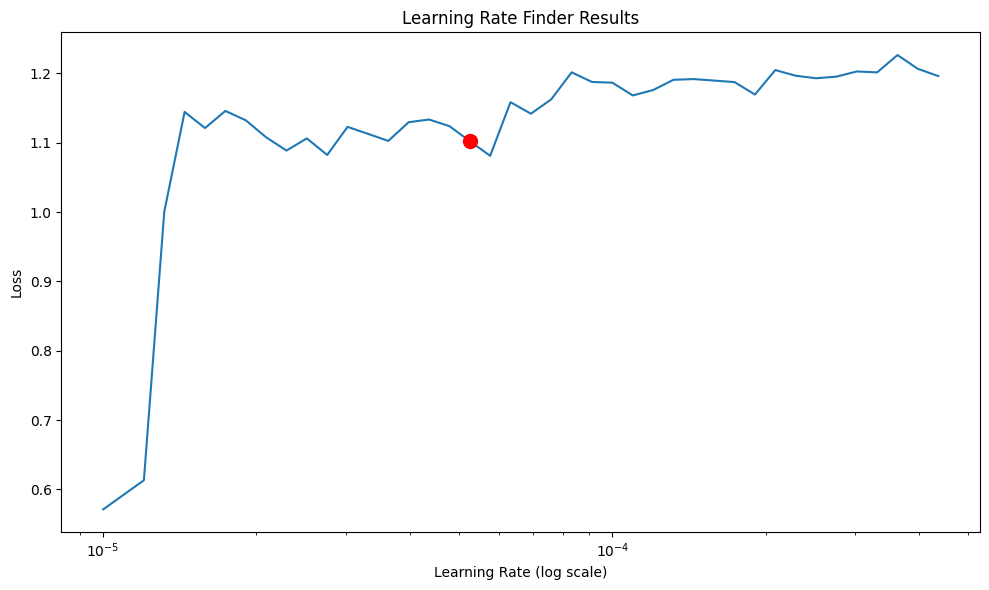

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Suggested learning rate: 0.00005248
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 573.26it/s]
Learning rate set to 3.630780547701014e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_59e7577b-59e0-416b-815b-f27b6a2acd13.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_59e7577b-59e0-416b-815b-f27b6a2acd13.ckpt


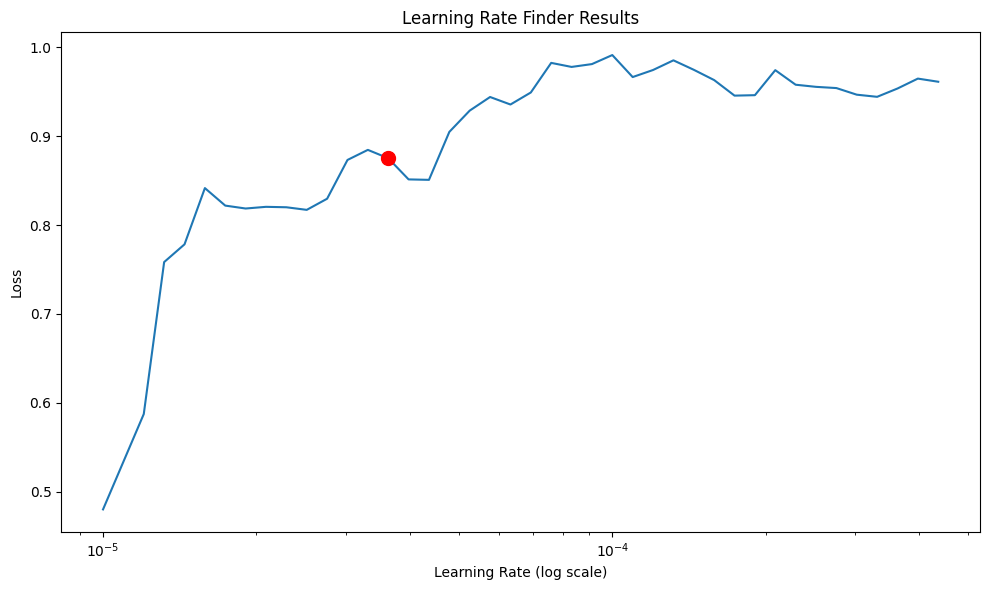

Suggested learning rate: 0.00003631


In [11]:
best_lr_GDP = lstm.find_learning_rate(lstm_df, inputs, 'log_GDP',min_lr=1e-5, max_lr=1e-1)
best_lr_hhd = lstm.find_learning_rate(lstm_df, inputs, 'household_debt',min_lr=1e-5, max_lr=1e-1)

# GDP_model_lstm, GDP_predictions_lstm, GDP_lstm_metrics, GDP_scaler_X, GDP_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['log_GDP'], learning_rate = best_lr, num_epochs= 500)


In [12]:
# best_lr_hhd = lstm.find_learning_rate(lstm_df, inputs, 'household_debt',min_lr=1e-5, max_lr=1e-1)

# hhd_model_lstm, hhd_predictions_lstm, hhd_lstm_metrics, hhd_scaler_X, hhd_scaler_y = lstm.train_lstm_model(lstm_df, inputs, ['household_debt'], learning_rate = best_lr, num_epochs= 500)


In [13]:
param_dict = {
    'household_debt':{'learning_rate': best_lr_hhd, 'epochs': 1000},
    'log_GDP':{'learning_rate': best_lr_GDP, 'epochs': 1000},
}
variables = final_detrend.columns
model_scaler_dict = deepvar.get_model_and_scaler_window(lstm_df, variables, inputs, param_dict, LAGS)





# irf_predictions = autoregressive_predict(test_df, inputs, steps, model_dict, LAG, country_means=None)

# For country-specific predictions (add back country effects)
# country_predictions = autoregressive_predict(test_df, inputs, steps, model_dict, LAG, country_means=country_means)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_datal

In [14]:
inputs

['log_GDP_lag1',
 'log_GDP_lag2',
 'log_GDP_lag3',
 'household_debt_lag1',
 'household_debt_lag2',
 'household_debt_lag3']

In [15]:
country_means.loc["Argentina", "household_debt"]


0.046031746031746035

In [16]:
def test_errors(df, inputs_test, actuals_test, variable, dictionary, inputs, LAG, cross_sectional_means, country_means):
    lstm.set_seed()
    countries = df.index.get_level_values('Country').unique()
    df = df.drop(columns = inputs)
    total_squared_error = 0
    total_absolute_error = 0 
    total_samples = 0
    
    # Check if we're using windowed approach by examining the model structure
    is_windowed = hasattr(dictionary[variable][0], 'window_size') and dictionary[variable][0].window_size > 1
    window_size = dictionary[variable][0].window_size if is_windowed else 1
    
    for country in countries:
        actual_values = hp.get_country(actuals_test, country)
        input_values = hp.get_country(inputs_test, country)
        steps_to_predict = len(actual_values)
        
        # Use the appropriate prediction function based on whether we're using windows
        if is_windowed:
            predictions_dict = deepvar.autoregressive_predict_windowed(
                input_values, inputs, steps_to_predict, dictionary, LAG, window_size=window_size
            )
        else:
            predictions_dict = deepvar.autoregressive_predict(
                input_values, inputs, steps_to_predict, dictionary, LAG
            )
            
        prediction = predictions_dict[variable]
        
        # Get the time periods for the predictions
        time_periods = actual_values.index.get_level_values('TIME_PERIOD')
        # Add the corresponding cross-sectional means
        prediction = prediction + cross_sectional_means.loc[time_periods, variable].values + country_means.loc[country, variable]
        
        fitted_values = pd.DataFrame(prediction, columns=[variable])
        
        mse = hp.calculate_mse(actual_values, fitted_values, variable)
        total_squared_error += mse * len(actual_values[variable]) 
        
        mae = hp.calculate_mae(actual_values, fitted_values, variable)
        total_absolute_error += mae * len(actual_values[variable])
        
        total_samples += len(actual_values[variable])
    
    total_mse = total_squared_error / total_samples
    rmse = np.sqrt(total_mse)
    total_mae = total_absolute_error / total_samples
    return [total_mse, rmse, total_mae]

gdp_deepvar_metrics = test_errors(lstm_df, lstm_test, test_dt_var, 'log_GDP', model_scaler_dict, inputs, LAGS, cross_sectional_means, country_means)
hhd_deepvar_metrics = test_errors(lstm_df, lstm_test, test_dt_var, 'household_debt', model_scaler_dict, inputs, LAGS, cross_sectional_means, country_means)


   

In [17]:
def calculate_percent_improvement(deepvar_metrics, compare_metrics):
    improvements = {}
    
    # Define the metric names for clarity (order should match the input lists)
    metric_names = ['total_mse', 'rmse', 'total_mae']
    
    for i, metric in enumerate(metric_names):
        # Get the values for DeepVAR and the comparison model
        deepvar_value = deepvar_metrics[i]
        compare_value = compare_metrics[i]
        
        if compare_value != 0:  
            improvement = ((compare_value - deepvar_value) / compare_value) * 100
            improvements[metric] = improvement
        else:
            improvements[metric] = None  
    
    return improvements

# improvement_deepvar_vs_var_gdp = calculate_percent_improvement(gdp_deepvar_metrics, panel_var_pred['log_GDP'])
# print("GDP model improvement",improvement_deepvar_vs_var_gdp)


# improvement_deepvar_vs_var_hhd = calculate_percent_improvement(hhd_deepvar_metrics, panel_var_pred['household_debt'])
# print("household debt model improvement",improvement_deepvar_vs_var_hhd)



In [71]:
# countries = lstm_df.index.get_level_values("Country").unique()
# from var import var
# def plot_country_predictions_test(country, variable, inputs, lags, df, dict, train_dt_var, test_dt_var, final_detrend, cross_sectional_means, country_means, panel_predictions, train_fraction=0.8):
#     country_data = hp.get_country(df, country)
#     country_var_detrend_predict, _ = var.get_VAR_predict(final_detrend, train_dt_var, test_dt_var, country, lags)

#     # Get panel VAR predictions and add back means
#     panel_predictions_country = hp.get_country(panel_predictions, country)
#     panel_predictions_adjusted = panel_predictions_country.copy()
#     panel_predictions_adjusted[variable] = panel_predictions_adjusted[variable] + cross_sectional_means[variable]

#     # LSTM predictions 
#     country_test_data = hp.get_test_data(country_data, train_fraction=train_fraction)
#     lstm_predict = lstm.fill_forecast_values(country_data, inputs, variable, dict)
#     lstm_predict = lstm_predict + cross_sectional_means+country_means

#     # Deep var predictions
#     steps_to_predict = len(country_test_data)
#     deepvar_predict_dict = deepvar.autoregressive_predict(country_test_data, inputs, steps_to_predict, dict, lags)
#     deepvar_predict = deepvar_predict_dict[variable]
    
#     deepvar_predict_df = pd.DataFrame(
#         deepvar_predict, 
#         index=country_test_data.index,
#         columns=[variable]
#     )
    
#     deepvar_predict_df[variable] = deepvar_predict_df[variable] + cross_sectional_means[variable]+country_means[variable]

#     plt.figure(figsize = (12,6))

#     plt.plot(country_data.index.get_level_values('TIME_PERIOD'), country_data[variable], label=f"{country} Actual", color='skyblue')
#     plt.plot(country_var_detrend_predict.index.get_level_values('TIME_PERIOD'), country_var_detrend_predict[variable], label=f"{country} VAR Predicted", color='green', linestyle='--')
#     plt.plot(lstm_predict.index.get_level_values('TIME_PERIOD'), lstm_predict[variable], label=f"{country} LSTM Forecast", color='orange', linestyle='--')
#     plt.plot(deepvar_predict_df.index.get_level_values('TIME_PERIOD'), deepvar_predict_df[variable], label=f"{country} Deep VAR Forecast", color='red', linestyle='--')
#     plt.plot(panel_predictions_adjusted.index.get_level_values('TIME_PERIOD'),
#               panel_predictions_adjusted[variable], label='Panel VAR', color='purple')
    
#     plt.title(f'{variable} Predictions for {country} Compared to Actual')
#     plt.xlabel('Date')
#     plt.ylabel(f'{variable}')
    
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
    
#     plt.show()
    
# for country in countries:
#     plot_country_predictions_test(
#         country, 
#         'log_GDP', 
#         inputs, 
#         3, 
#         panel_var_df, 
#         model_scaler_dict, 
#         train_dt_var,
#         test_dt_var, 
#         final_detrend,
#         cross_sectional_means,
#         country_means, 
#         panel_var_pred
#     )


In [19]:
pvar_metrics_gdp = [
    hp.calculate_mse(test_dt_var, pvar_data_metrics_df, 'log_GDP'),
    np.sqrt(hp.calculate_mse(test_dt_var, pvar_data_metrics_df, 'log_GDP')),
    hp.calculate_mae(test_dt_var, pvar_data_metrics_df, 'log_GDP')
]

pvar_metrics_hhd = [
    hp.calculate_mse(test_dt_var, pvar_data_metrics_df, 'household_debt'),
    np.sqrt(hp.calculate_mse(test_dt_var, pvar_data_metrics_df, 'household_debt')),
    hp.calculate_mae(test_dt_var, pvar_data_metrics_df, 'household_debt')
]

improvement_deepvar_vs_var_gdp = calculate_percent_improvement(gdp_deepvar_metrics,pvar_metrics_gdp)
print("GDP model improvement",improvement_deepvar_vs_var_gdp)


improvement_deepvar_vs_var_hhd = calculate_percent_improvement(hhd_deepvar_metrics, pvar_metrics_hhd)
print("household debt model improvement",improvement_deepvar_vs_var_hhd)

GDP model improvement {'total_mse': -12.394158878936205, 'rmse': -6.016111454314429, 'total_mae': -13.262839253075398}
household debt model improvement {'total_mse': -7.5490509322130945, 'rmse': -3.705858528924534, 'total_mae': -12.768556383183274}


In [20]:
GDP_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, LAGS, 'log_GDP')
hhd_var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, LAGS, 'household_debt')

improvement_deepvar_vs_var_gdp = calculate_percent_improvement(gdp_deepvar_metrics,GDP_var_metrics )
print("GDP model improvement",improvement_deepvar_vs_var_gdp)


improvement_deepvar_vs_var_hhd = calculate_percent_improvement(hhd_deepvar_metrics, hhd_var_metrics)
print("household debt model improvement",improvement_deepvar_vs_var_hhd)


GDP model improvement {'total_mse': -67.75074646714899, 'rmse': -29.518626640012286, 'total_mae': -68.3767709699028}
household debt model improvement {'total_mse': 15.50556675794031, 'rmse': 8.079146412764592, 'total_mae': 0.05845619807568111}


In [21]:
gdp_latex = hp.create_model_comparison_latex_table(gdp_deepvar_metrics, GDP_var_metrics, pvar_metrics_gdp)


hhd_latex = hp.create_model_comparison_latex_table(hhd_deepvar_metrics, hhd_var_metrics, pvar_metrics_hhd)

In [22]:
# gdp_latex 

In [23]:
hhd_latex

'\\begin{table}[htbp]\n\\centering\n\\caption{Model Performance Comparison}\n\\begin{tabular}{lccc}\n\\hline\n\\textbf{Metric} & \\textbf{DeepVAR} & \\textbf{VAR} & \\textbf{Panel VAR} \\\\\n\\hline\nMean Squared Error (MSE) & 0.441175 & 0.522135 & 0.410208  \\\\\nRoot Mean Squared Error (RMSE) & 0.664210 & 0.722589 & 0.640475  \\\\\nMean Absolute Error (MAE) & 0.514759 & 0.515060 & 0.456474  \\\\\n\\hline\n\\end{tabular}\n\\end{table}'

In [24]:
# # ... existing code ...
# import deepvar.hyperopt as hyperopt
# import time

# # Define the variables you want to optimize
# variables = final_detrend.columns  # ['household_debt', 'log_GDP']

# # Start timer to track optimization time
# start_time = time.time()

# print("Starting hyperparameter optimization for DeepVAR models...")
# # Run hyperparameter optimization for all variables
# best_params = hyperopt.optimize_all_variables(
#     df=lstm_df,  # Your training dataframe
#     variables=variables,  # Variables to predict
#     inputs=inputs,  # Input features
#     n_trials=30  # Number of trials per variable (adjust based on your time constraints)
# )

# # Print optimization time
# optimization_time = time.time() - start_time
# print(f"Hyperparameter optimization completed in {optimization_time:.2f} seconds")

# # Print the best hyperparameters for each variable
# for var, params in best_params.items():
#     print(f"\nBest hyperparameters for {var}:")
#     for param_name, param_value in params.items():
#         print(f"  {param_name}: {param_value}")

# # Train models with the optimized hyperparameters
# print("\nTraining DeepVAR models with optimized hyperparameters...")
# optimized_model_dict = {}

# for var in variables:
#     print(f"Training model for {var} with optimized hyperparameters...")
#     params = best_params[var]
    
#     model_params = {
#         'learning_rate': params['learning_rate'],
#         'hidden_size': params['hidden_size'],
#         'dropout': params['dropout'],
#         'weight_decay': params['weight_decay'],
#         'batch_size': params['batch_size'],
#         'num_epochs': 500  # Use a fixed number of epochs
#     }
    
#     # Train the model with the optimized parameters
#     model, predictions, metrics, scaler_X, scaler_y = lstm.train_lstm_model(
#         lstm_df, 
#         inputs, 
#         [var], 
#         **model_params
#     )
    
#     # Store in the format expected by autoregressive_predict
#     optimized_model_dict[var] = (model, predictions, metrics, scaler_X, scaler_y)

# # Now you can use these optimized models for prediction and evaluation
# print("\nEvaluating optimized DeepVAR models...")

# # Calculate test errors for the optimized models
# gdp_optimized_metrics = test_errors(
#     lstm_df, lstm_test, test_dt_var, 'log_GDP', 
#     optimized_model_dict, inputs, LAGS, 
#     cross_sectional_means, country_means
# )

# hhd_optimized_metrics = test_errors(
#     lstm_df, lstm_test, test_dt_var, 'household_debt', 
#     optimized_model_dict, inputs, LAGS, 
#     cross_sectional_means, country_means
# )

# # Compare the optimized models with the previous models
# print("\nComparison of model performance:")
# print("\nGDP Model:")
# print(f"{'Metric':<25} {'Original DeepVAR':<15} {'Optimized DeepVAR':<15}")
# print(f"{'MSE':<25} {gdp_deepvar_metrics[0]:<15.6f} {gdp_optimized_metrics[0]:<15.6f}")
# print(f"{'RMSE':<25} {gdp_deepvar_metrics[1]:<15.6f} {gdp_optimized_metrics[1]:<15.6f}")
# print(f"{'MAE':<25} {gdp_deepvar_metrics[2]:<15.6f} {gdp_optimized_metrics[2]:<15.6f}")

# print("\nHousehold Debt Model:")
# print(f"{'Metric':<25} {'Original DeepVAR':<15} {'Optimized DeepVAR':<15}")
# print(f"{'MSE':<25} {hhd_deepvar_metrics[0]:<15.6f} {hhd_optimized_metrics[0]:<15.6f}")
# print(f"{'RMSE':<25} {hhd_deepvar_metrics[1]:<15.6f} {hhd_optimized_metrics[1]:<15.6f}")
# print(f"{'MAE':<25} {hhd_deepvar_metrics[2]:<15.6f} {hhd_optimized_metrics[2]:<15.6f}")

# # Calculate improvement percentages
# gdp_improvement = {
#     'MSE': ((gdp_deepvar_metrics[0] - gdp_optimized_metrics[0]) / gdp_deepvar_metrics[0]) * 100,
#     'RMSE': ((gdp_deepvar_metrics[1] - gdp_optimized_metrics[1]) / gdp_deepvar_metrics[1]) * 100,
#     'MAE': ((gdp_deepvar_metrics[2] - gdp_optimized_metrics[2]) / gdp_deepvar_metrics[2]) * 100
# }

# hhd_improvement = {
#     'MSE': ((hhd_deepvar_metrics[0] - hhd_optimized_metrics[0]) / hhd_deepvar_metrics[0]) * 100,
#     'RMSE': ((hhd_deepvar_metrics[1] - hhd_optimized_metrics[1]) / hhd_deepvar_metrics[1]) * 100,
#     'MAE': ((hhd_deepvar_metrics[2] - hhd_optimized_metrics[2]) / hhd_deepvar_metrics[2]) * 100
# }

# print("\nImprovement with optimized hyperparameters:")
# print("\nGDP Model:")
# print(f"{'Metric':<25} {'Improvement (%)':<15}")
# print(f"{'MSE':<25} {gdp_improvement['MSE']:<15.2f}")
# print(f"{'RMSE':<25} {gdp_improvement['RMSE']:<15.2f}")
# print(f"{'MAE':<25} {gdp_improvement['MAE']:<15.2f}")

# print("\nHousehold Debt Model:")
# print(f"{'Metric':<25} {'Improvement (%)':<15}")
# print(f"{'MSE':<25} {hhd_improvement['MSE']:<15.2f}")
# print(f"{'RMSE':<25} {hhd_improvement['RMSE']:<15.2f}")
# print(f"{'MAE':<25} {hhd_improvement['MAE']:<15.2f}")


In [25]:
# from var import var
# for country in countries:
#     plot_country_predictions_test(
#         country, 
#         'log_GDP', 
#         inputs, 
#         3, 
#         panel_var_df, 
#         optimized_model_dict,  # Use optimized models
#         train_dt_var,
#         test_dt_var, 
#         final_detrend,
#         cross_sectional_means,
#         country_means, 
#         panel_var_pred
#     )

In [26]:
# import deepvar.hyperopt as hyperopt
# import time

# # Define the variables you want to optimize
# variables = final_detrend.columns  # ['household_debt', 'log_GDP']

# # Start timer to track optimization time
# start_time = time.time()

# print("Starting hyperparameter optimization for DeepVAR models...")
# # Run hyperparameter optimization for all variables
# best_params = hyperopt.optimize_all_variables(
#     df=lstm_df,  # Your training dataframe
#     variables=variables,  # Variables to predict
#     inputs=inputs,  # Input features
#     n_trials=30  # Number of trials per variable (adjust based on your time constraints)
# )

# # Print optimization time
# optimization_time = time.time() - start_time
# print(f"Hyperparameter optimization completed in {optimization_time:.2f} seconds")

# # Print the best hyperparameters for each variable
# for var, params in best_params.items():
#     print(f"\nBest hyperparameters for {var}:")
#     for param_name, param_value in params.items():
#         print(f"  {param_name}: {param_value}")

# # Train models with the optimized hyperparameters
# print("\nTraining DeepVAR models with optimized hyperparameters...")
# optimized_model_dict = {}

# for var in variables:
#     print(f"Training model for {var} with optimized hyperparameters...")
#     params = best_params[var]
    
#     # Use the appropriate learning rate based on the variable
#     if var == 'log_GDP':
#         learning_rate = best_lr_GDP
#     elif var == 'household_debt':
#         learning_rate = best_lr_hhd
#     else:
#         learning_rate = params['learning_rate']
    
#     model_params = {
#         'learning_rate': learning_rate,  
#         'hidden_size': params['hidden_size'],
#         'dropout': params['dropout'],
#         'weight_decay': params['weight_decay'],
#         'batch_size': params['batch_size'],
#         'num_epochs': 500  # Use a fixed number of epochs
#     }
    
#     # Train the model with the optimized parameters
#     model, predictions, metrics, scaler_X, scaler_y = lstm.train_lstm_model(
#         lstm_df, 
#         inputs, 
#         [var], 
#         **model_params
#     )
    
#     # Store in the format expected by autoregressive_predict
#     optimized_model_dict[var] = (model, predictions, metrics, scaler_X, scaler_y)

# # Now you can use these optimized models for prediction and evaluation
# print("\nEvaluating optimized DeepVAR models...")

# # Calculate test errors for the optimized models
# gdp_optimized_metrics = test_errors(
#     lstm_df, lstm_test, test_dt_var, 'log_GDP', 
#     optimized_model_dict, inputs, LAGS, 
#     cross_sectional_means, country_means
# )

# hhd_optimized_metrics = test_errors(
#     lstm_df, lstm_test, test_dt_var, 'household_debt', 
#     optimized_model_dict, inputs, LAGS, 
#     cross_sectional_means, country_means
# )

# # Compare the optimized models with the previous models
# print("\nComparison of model performance:")
# print("\nGDP Model:")
# print(f"{'Metric':<25} {'Original DeepVAR':<15} {'Optimized DeepVAR':<15}")
# print(f"{'MSE':<25} {gdp_deepvar_metrics[0]:<15.6f} {gdp_optimized_metrics[0]:<15.6f}")
# print(f"{'RMSE':<25} {gdp_deepvar_metrics[1]:<15.6f} {gdp_optimized_metrics[1]:<15.6f}")
# print(f"{'MAE':<25} {gdp_deepvar_metrics[2]:<15.6f} {gdp_optimized_metrics[2]:<15.6f}")

# print("\nHousehold Debt Model:")
# print(f"{'Metric':<25} {'Original DeepVAR':<15} {'Optimized DeepVAR':<15}")
# print(f"{'MSE':<25} {hhd_deepvar_metrics[0]:<15.6f} {hhd_optimized_metrics[0]:<15.6f}")
# print(f"{'RMSE':<25} {hhd_deepvar_metrics[1]:<15.6f} {hhd_optimized_metrics[1]:<15.6f}")
# print(f"{'MAE':<25} {hhd_deepvar_metrics[2]:<15.6f} {hhd_optimized_metrics[2]:<15.6f}")

# # Calculate improvement percentages
# gdp_improvement = {
#     'MSE': ((gdp_deepvar_metrics[0] - gdp_optimized_metrics[0]) / gdp_deepvar_metrics[0]) * 100,
#     'RMSE': ((gdp_deepvar_metrics[1] - gdp_optimized_metrics[1]) / gdp_deepvar_metrics[1]) * 100,
#     'MAE': ((gdp_deepvar_metrics[2] - gdp_optimized_metrics[2]) / gdp_deepvar_metrics[2]) * 100
# }

# hhd_improvement = {
#     'MSE': ((hhd_deepvar_metrics[0] - hhd_optimized_metrics[0]) / hhd_deepvar_metrics[0]) * 100,
#     'RMSE': ((hhd_deepvar_metrics[1] - hhd_optimized_metrics[1]) / hhd_deepvar_metrics[1]) * 100,
#     'MAE': ((hhd_deepvar_metrics[2] - hhd_optimized_metrics[2]) / hhd_deepvar_metrics[2]) * 100
# }

# print("\nImprovement with optimized hyperparameters:")
# print("\nGDP Model:")
# print(f"{'Metric':<25} {'Improvement (%)':<15}")
# print(f"{'MSE':<25} {gdp_improvement['MSE']:<15.2f}")
# print(f"{'RMSE':<25} {gdp_improvement['RMSE']:<15.2f}")
# print(f"{'MAE':<25} {gdp_improvement['MAE']:<15.2f}")

# print("\nHousehold Debt Model:")
# print(f"{'Metric':<25} {'Improvement (%)':<15}")
# print(f"{'MSE':<25} {hhd_improvement['MSE']:<15.2f}")
# print(f"{'RMSE':<25} {hhd_improvement['RMSE']:<15.2f}")
# print(f"{'MAE':<25} {hhd_improvement['MAE']:<15.2f}")


In [27]:
# gdp_improvement = {
#     'MSE': ((GDP_var_metrics[0] - gdp_optimized_metrics[0]) / GDP_var_metrics[0]) * 100,
#     'RMSE': ((GDP_var_metrics[1] - gdp_optimized_metrics[1]) / GDP_var_metrics[1]) * 100,
#     'MAE': ((GDP_var_metrics[2] - gdp_optimized_metrics[2]) / GDP_var_metrics[2]) * 100
# }
# gdp_improvement

In [28]:

# gdp_improvement = {
#     'MSE': ((GDP_var_metrics[0] - gdp_optimized_metrics[0]) / GDP_var_metrics[0]) * 100,
#     'RMSE': ((GDP_var_metrics[1] - gdp_optimized_metrics[1]) / GDP_var_metrics[1]) * 100,
#     'MAE': ((GDP_var_metrics[2] - gdp_optimized_metrics[2]) / GDP_var_metrics[2]) * 100
# }

# # Calculate improvement percentages for household debt compared to VAR
# hhd_improvement = {
#     'MSE': ((hhd_var_metrics[0] - hhd_optimized_metrics[0]) / hhd_var_metrics[0]) * 100,
#     'RMSE': ((hhd_var_metrics[1] - hhd_optimized_metrics[1]) / hhd_var_metrics[1]) * 100,
#     'MAE': ((hhd_var_metrics[2] - hhd_optimized_metrics[2]) / hhd_var_metrics[2]) * 100
# }

# # Calculate improvement percentages for GDP compared to Panel VAR
# gdp_improvement_vs_panel = {
#     'MSE': ((pvar_metrics_gdp[0] - gdp_optimized_metrics[0]) / pvar_metrics_gdp[0]) * 100,
#     'RMSE': ((pvar_metrics_gdp[1] - gdp_optimized_metrics[1]) / pvar_metrics_gdp[1]) * 100,
#     'MAE': ((pvar_metrics_gdp[2] - gdp_optimized_metrics[2]) / pvar_metrics_gdp[2]) * 100
# }

# # Calculate improvement percentages for household debt compared to Panel VAR
# hhd_improvement_vs_panel = {
#     'MSE': ((pvar_metrics_hhd[0] - hhd_optimized_metrics[0]) / pvar_metrics_hhd[0]) * 100,
#     'RMSE': ((pvar_metrics_hhd[1] - hhd_optimized_metrics[1]) / pvar_metrics_hhd[1]) * 100,
#     'MAE': ((pvar_metrics_hhd[2] - hhd_optimized_metrics[2]) / pvar_metrics_hhd[2]) * 100
# }

# # Display the results
# print("\nGDP improvement vs VAR:")
# print(gdp_improvement)

# print("\nHousehold debt improvement vs VAR:")
# print(hhd_improvement)

# print("\nGDP improvement vs Panel VAR:")
# print(gdp_improvement_vs_panel)

# print("\nHousehold debt improvement vs Panel VAR:")
# print(hhd_improvement_vs_panel)


In [29]:
num_variables_deepvar = len(inputs)
df_zeros = pd.DataFrame(np.zeros((1, num_variables_deepvar)), columns=inputs)


In [30]:
# Get standard deviations for the variables
std_devs = lstm_df[['household_debt', 'log_GDP']].std()
print("Standard deviations of variables:")
print(std_devs)

std_multipliers = [-3, -2, -1, 1, 2, 3]

household_debt_shocks = {m: std_devs['household_debt'] * m for m in std_multipliers}
log_gdp_shocks = {m: std_devs['log_GDP'] * m for m in std_multipliers}

print(f"-3 std dev shock for household debt: {household_debt_shocks[-3]}")

Standard deviations of variables:
household_debt    0.738476
log_GDP           0.009769
dtype: float64
-3 std dev shock for household debt: -2.2154266791664345


In [31]:
hp.get_country(lstm_df[['household_debt', 'log_GDP']], "United States").mean()

household_debt   -0.225395
log_GDP          -0.007443
dtype: float64

In [32]:
# from deepvar import irf

# shock = 3
# plot1_irf_results = irf.predict(df_zeros, inputs, 'household_debt_lag1', household_debt_shocks[shock], 'log_GDP', 20, optimized_model_dict, LAGS)
# plot1_title = f'%Δ GDP Impulse Response Function (Shock: {shock} Std Deviation)'
# plot1_var = '%Δ GDP'
# irf.plot(plot1_irf_results, 'log_hhd', plot1_title, plot1_var)
# sum(plot1_irf_results)

In [33]:
def plot_irf_with_multiple_shocks(df_zeros, inputs, shock_var, response_var, 
                                 model_dict, lags, periods=10, 
                                 std_multipliers=None, figsize=(14, 8)):
    """
    Plot Impulse Response Functions for multiple shock sizes.
    """
    # Get standard deviation of the variable to shock
    base_var = shock_var.split('_lag')[0]
    response_base_var = response_var
    
    # Get standard deviations from the data
    std_devs = lstm_df[[base_var, response_base_var]].std()
    
    # Define standardized shock sizes if not provided
    if std_multipliers is None:
        std_multipliers = [-3, -2, -1, 1, 2, 3]
    
    # Sort multipliers from negative to positive
    std_multipliers.sort()
    
    # Create shock sizes
    shock_sizes = [std_devs[base_var] * m for m in std_multipliers]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create color map
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(std_multipliers)))
    
    # Check if we're using windowed approach
    is_windowed = hasattr(model_dict[response_var][0], 'window_size') and model_dict[response_var][0].window_size > 1
    window_size = model_dict[response_var][0].window_size if is_windowed else 1
    
    # Plot IRFs for different shock sizes
    for i, (mult, shock, color) in enumerate(zip(std_multipliers, shock_sizes, colors)):
        if is_windowed:
            irf_result = irf.predict_windowed(df_zeros, inputs, shock_var, shock, response_var, periods, model_dict, lags, window_size=window_size)
        else:
            irf_result = irf.predict(df_zeros, inputs, shock_var, shock, response_var, periods, model_dict, lags)
            
        label = f'{mult:+d} std dev shock ({shock:.4f})'
        ax.plot(irf_result, label=label, color=color, linewidth=2)
    
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Set title and labels
    shock_name = base_var.replace('_', ' ').title()
    response_name = response_var.replace('_', ' ').title()
    
    if response_var == 'log_GDP':
        response_label = '%Δ GDP'
    else:
        response_label = f'Δ {response_name}'
        
    ax.set_title(f'{response_name} Response to {shock_name} Shocks')
    ax.set_xlabel('Periods')
    ax.set_ylabel(response_label)
    
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
std_multipliers = [-3, -2, -1, 1, 2, 3]




Evaluating models with 1 lags...
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
      

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_datal

Optimizing hyperparameters for household_debt


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 


Best hyperparameters for log_GDP with lag 1:
  learning_rate: 0.000124530028757876
  hidden_size: 16
  num_layers: 3
  dropout: 0.1
  weight_decay: 0.01
  batch_size: 64

Best hyperparameters for household_debt with lag 1:
  learning_rate: 2.2139290514335146e-05
  hidden_size: 16
  num_layers: 1
  dropout: 0.4
  weight_decay: 0.0001
  batch_size: 128
Training model for log_GDP with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 565.57it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_4ac9e9f9-21c6-41db-9359-207c192a930a.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_4ac9e9f9-21c6-41db-9359-207c192a930a.ckpt


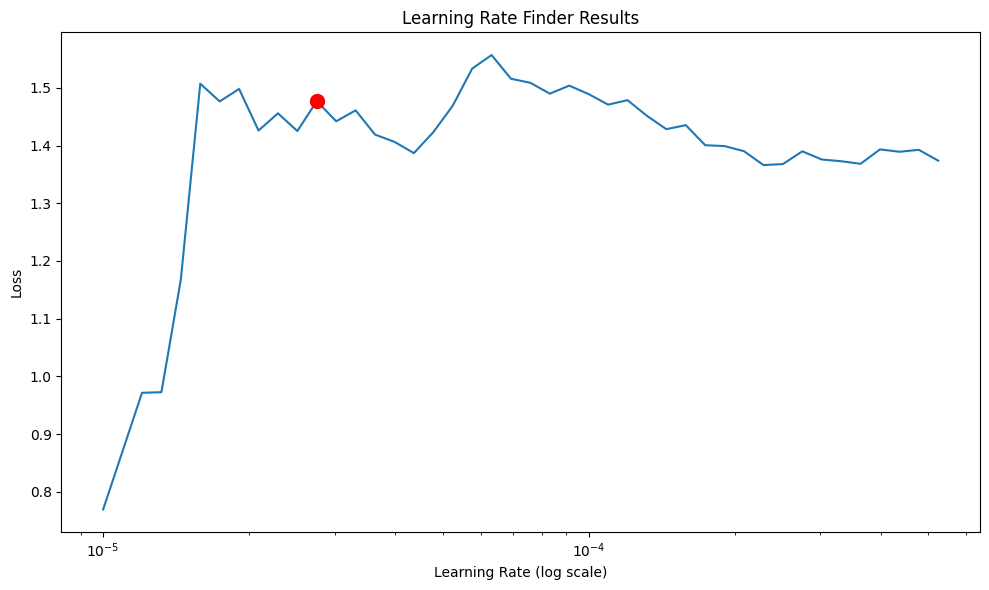

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00002754


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Training model for household_debt with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 561.29it/s]
Learning rate set to 0.00015848931924611134
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_99a1e321-83b0-4f4e-b2bc-bb4530b8db98.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_99a1e321-83b0-4f4e-b2bc-bb4530b8db98.ckpt


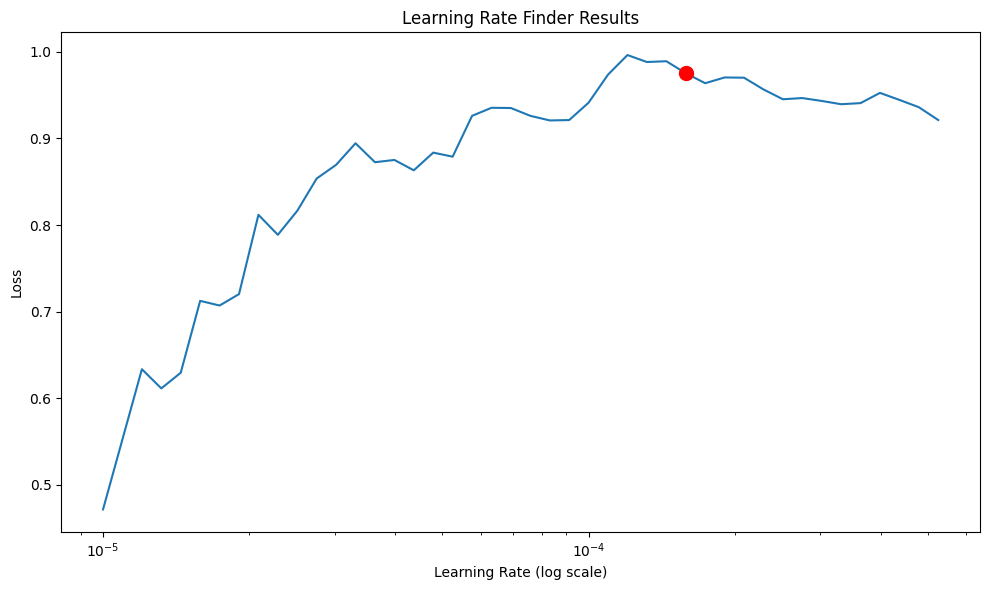

Suggested learning rate: 0.00015849


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_datal

In [45]:
import deepvar.hyperopt_window as hyperopt
from var import var
import random
import numpy as np
import torch
import optuna
def evaluate_models_with_lags(final_detrend, train_dt_var, test_dt_var, variables, 
                             max_lags=6, n_trials=20, seed=42, window_size=4):
    """
    Evaluate VAR, Panel VAR, and DeepVAR models with different lag lengths
    
    Parameters:
    -----------
    final_detrend : DataFrame
        Detrended data
    train_dt_var : DataFrame
        Training data
    test_dt_var : DataFrame
        Test data
    variables : list
        List of variables to evaluate
    max_lags : int
        Maximum number of lags to evaluate
    n_trials : int
        Number of hyperparameter optimization trials
    seed : int
        Random seed for reproducibility
    window_size : int
        Size of the sliding window for the windowed approach
    
    Returns:
    --------
    tuple
        (results_dict, optimized_models_dict)
    """
    
    # Set seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Also set the seed for Optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    results = {
        'VAR': {var_name: {lag: {} for lag in range(1, max_lags+1)} for var_name in variables},
        'PVAR': {var_name: {lag: {} for lag in range(1, max_lags+1)} for var_name in variables},
        'DeepVAR': {var_name: {lag: {} for lag in range(1, max_lags+1)} for var_name in variables}
    }
    optimized_models_by_lag = {}
    
    for lag in range(1, max_lags+1):
        print(f"\nEvaluating models with {lag} lags...")
        
        # For each lag length, create a new lstm_df with the appropriate number of lags
        demeaned_df, cross_sectional_means, country_means = deepvar.prepare_data_with_fixed_effects(final_detrend, variables=variables)
        lstm_df = lstm.create_lstm_data(demeaned_df, lag)
        lstm_train, lstm_val, lstm_test = lstm.train_val_test_split(lstm_df)
        
        # Generate inputs for this lag specification
        inputs = lstm.get_lstm_input(final_detrend, lag)
        
        # 1. Evaluate VAR models
        for var_name in variables:
            var_metrics = var.get_test_errors(final_detrend, train_dt_var, test_dt_var, lag, var_name)
            results['VAR'][var_name][lag] = {
                'MSE': var_metrics[0],
                'RMSE': var_metrics[1],
                'MAE': var_metrics[2]
            }
        
        # 2. Evaluate Panel VAR models
        pvar_dict = {
            lag: f'./pvarcoefs_GDPHHD/coef{lag}_GDPHHD.xlsx'
        }
        
        # Create panel VAR data with appropriate lags
        panel_var_df = lstm.create_lstm_data(final_detrend, lag)
        
        # Run panel VAR predictions
        try:
            panel_var_pred, _ = run_panel_VAR_predict_new(panel_var_df, lstm_test, lag, pvar_dict)
            pvar_data_metrics_df = panel_var_pred + cross_sectional_means + country_means
            
            for var_name in variables:
                pvar_metrics = [
                    hp.calculate_mse(test_dt_var, pvar_data_metrics_df, var_name),
                    np.sqrt(hp.calculate_mse(test_dt_var, pvar_data_metrics_df, var_name)),
                    hp.calculate_mae(test_dt_var, pvar_data_metrics_df, var_name)
                ]
                results['PVAR'][var_name][lag] = {
                    'MSE': pvar_metrics[0],
                    'RMSE': pvar_metrics[1],
                    'MAE': pvar_metrics[2]
                }
        except Exception as e:
            print(f"Error evaluating Panel VAR with lag {lag}: {e}")
            # Set default values if Panel VAR fails
            for var_name in variables:
                results['PVAR'][var_name][lag] = {
                    'MSE': float('nan'),
                    'RMSE': float('nan'),
                    'MAE': float('nan')
                }
        
        # 3. Train and evaluate DeepVAR models with hyperparameter optimization
        print(f"Starting hyperparameter optimization for lag {lag}...")
        
        # Set seed for hyperparameter optimization
        lstm.set_seed(seed=seed)
        
        # Create a fixed seed for Optuna study
        optuna_seed = seed + lag  # Different seed for each lag to avoid identical results
        
        # Run hyperparameter optimization for all variables with fixed seed
        best_params = {}
        for variable in variables:
            print(f"Optimizing hyperparameters for {variable}")
            
            # Prepare data with fixed seed
            (X_train, y_train), (X_val, y_val), _, _, _ = lstm.prepare_lstm_data(lstm_df, inputs, [variable])
            
            # Create Optuna study with fixed seed
            sampler = optuna.samplers.TPESampler(seed=optuna_seed)
            study = optuna.create_study(direction="minimize", sampler=sampler)
            
            # Define objective function
            from functools import partial
            objective_func = partial(
                hyperopt.objective,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                input_size=X_train.shape[2],
            )
            
            # Run optimization
            study.optimize(objective_func, n_trials=n_trials)
            
            # Store best parameters
            best_params[variable] = study.best_params
        
        # Print the best hyperparameters for each variable
        for var_name in variables:
            print(f"\nBest hyperparameters for {var_name} with lag {lag}:")
            for param_name, param_value in best_params[var_name].items():
                print(f"  {param_name}: {param_value}")
        
        # Train models with the optimized hyperparameters
        optimized_model_dict = {}
        
        for var_name in variables:
            print(f"Training model for {var_name} with optimized hyperparameters...")
            params = best_params[var_name]
            
            # Reset seed before finding learning rate
            lstm.set_seed(seed=seed)
            
            # Find optimal learning rate
            best_lr = lstm.find_learning_rate(lstm_df, inputs, var_name, min_lr=1e-5, max_lr=1e-1)
            
            model_params = {
                'learning_rate': best_lr,
                'hidden_size': params['hidden_size'],
                'dropout': params['dropout'],
                'weight_decay': params['weight_decay'],
                'batch_size': params['batch_size'],
                'num_epochs': 500,  # Use a fixed number of epochs
                'windows': window_size  # Set window size
            }
            
            # Reset seed before training
            lstm.set_seed(seed=seed)
            
            
            model, predictions, metrics, scaler_X, scaler_y = lstm.train_lstm_model_windows(
                lstm_df, 
                inputs, 
                [var_name], 
                **model_params
            )
            
        
            optimized_model_dict[var_name] = (model, predictions, metrics, scaler_X, scaler_y)
        
        optimized_models_by_lag[lag] = {
            'model_dict': optimized_model_dict,
            'inputs': inputs
        }

        # Evaluate DeepVAR models
        for var_name in variables:
            deepvar_metrics = test_errors(
                lstm_df, lstm_test, test_dt_var, var_name, 
                optimized_model_dict, inputs, lag, 
                cross_sectional_means, country_means
            )
            results['DeepVAR'][var_name][lag] = {
                'MSE': deepvar_metrics[0],
                'RMSE': deepvar_metrics[1],
                'MAE': deepvar_metrics[2]
            }
    
    return results, optimized_models_by_lag

def create_latex_table_from_results(results, variables):
    """
    Create a LaTeX table from the evaluation results
    """
    latex_tables = {}
    
    for var_name in variables:
        # Start LaTeX table
        latex = "\\begin{table}[htbp]\n"
        latex += "\\centering\n"
        latex += f"\\caption{{Performance Comparison for {var_name}}}\n"
        latex += "\\begin{tabular}{lccccccc}\n"
        latex += "\\hline\n"
        latex += "\\textbf{Model} & \\textbf{Metric} & \\textbf{Lag 1} & \\textbf{Lag 2} & \\textbf{Lag 3} & \\textbf{Lag 4} & \\textbf{Lag 5} & \\textbf{Lag 6} \\\\\n"
        latex += "\\hline\n"
        
        
        for model in ['VAR', 'PVAR', 'DeepVAR']:
            # MSE row
            latex += f"{model} & MSE "
            for lag in range(1, 7):
                if lag in results[model][var_name]:
                    latex += f"& {results[model][var_name][lag]['MSE']:.6f} "
                else:
                    latex += "& - "
            latex += "\\\\\n"
            
            # RMSE row
            latex += f" & RMSE "
            for lag in range(1, 7):
                if lag in results[model][var_name]:
                    latex += f"& {results[model][var_name][lag]['RMSE']:.6f} "
                else:
                    latex += "& - "
            latex += "\\\\\n"
            
            # MAE row
            latex += f" & MAE "
            for lag in range(1, 7):
                if lag in results[model][var_name]:
                    latex += f"& {results[model][var_name][lag]['MAE']:.6f} "
                else:
                    latex += "& - "
            latex += "\\\\\n"
            
            
            if model != 'DeepVAR':
                latex += "\\hline\n"
        
        
        latex += "\\hline\n"
        latex += "\\end{tabular}\n"
        latex += "\\end{table}"
        
        latex_tables[var_name] = latex
    
    return latex_tables






Evaluating models with 1 lags...
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
      

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Optimizing hyperparameters for household_debt


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 


Best hyperparameters for log_GDP with lag 1:
  learning_rate: 0.000124530028757876
  hidden_size: 16
  num_layers: 3
  dropout: 0.1
  weight_decay: 0.01
  batch_size: 64

Best hyperparameters for household_debt with lag 1:
  learning_rate: 2.2139290514335146e-05
  hidden_size: 16
  num_layers: 1
  dropout: 0.4
  weight_decay: 0.0001
  batch_size: 128
Training model for log_GDP with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 637.51it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_c1810bd2-95a0-4437-bbf7-c6c51845e416.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_c1810bd2-95a0-4437-bbf7-c6c51845e416.ckpt


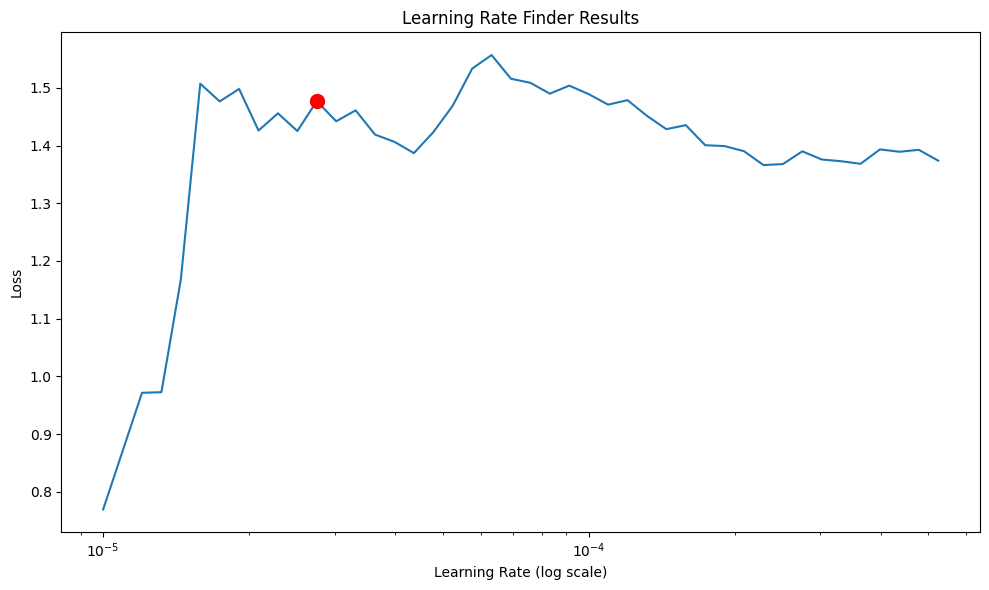

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00002754


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Training model for household_debt with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 581.06it/s]
Learning rate set to 0.00015848931924611134
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_d8ed134c-8ae2-4802-8cc0-f210cedade73.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_d8ed134c-8ae2-4802-8cc0-f210cedade73.ckpt


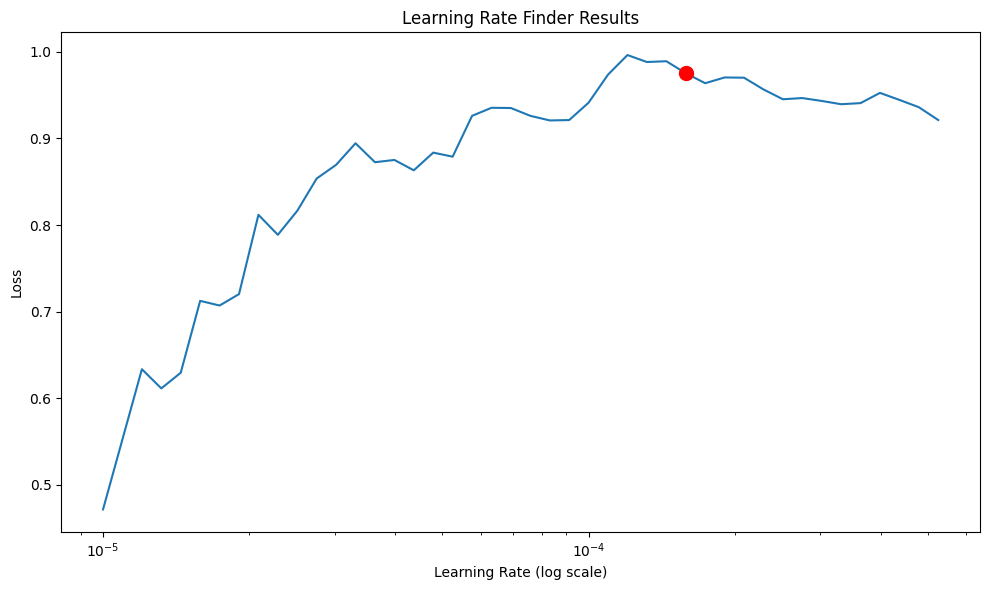

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00015849


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

In [73]:
max_lags_to_evaluate = 1 
window_size = 6
variables_to_evaluate = ['log_GDP', 'household_debt']

# takes a while to run
all_results, model_dict_1 = evaluate_models_with_lags(
    final_detrend, 
    train_dt_var, 
    test_dt_var, 
    variables_to_evaluate,  
    # cross_sectional_means, 
    # country_means,
    max_lags=max_lags_to_evaluate,
    window_size=window_size
)

In [77]:
def calculate_model_improvements(results_dict, base_model='DeepVAR', compare_models=None):
    improvements = {}
    
    variables = list(results_dict[base_model].keys())
    
    for variable in variables:
        improvements[variable] = {}
        
        for lag in results_dict[base_model][variable].keys():
        # for lag in range(5,6):
            improvements[variable][lag] = {}
            
            for compare_model in compare_models:
                if compare_model not in results_dict:
                    continue
                    
                if variable not in results_dict[compare_model]:
                    continue
                    
                if lag not in results_dict[compare_model][variable]:
                    continue
                
                improvements[variable][lag][compare_model] = {}
                
                # calculate improvment
                for metric in ['MSE', 'RMSE', 'MAE']:
                    print(base_model, variable,lag,metric)
                    base_value = results_dict[base_model][variable][lag][metric]
                    compare_value = results_dict[compare_model][variable][lag][metric]
                    
                    if compare_value != 0:
                        # positive % change means base_model has lower error
                        improvement = ((compare_value - base_value) / compare_value) * 100
                        improvements[variable][lag][compare_model][metric] = improvement
                    else:
                        improvements[variable][lag][compare_model][metric] = None
    
    return improvements

improvements = calculate_model_improvements(all_results)


Improvements for log_GDP:
  Lag 1:
    vs VAR:
      MSE: 11.17%
      RMSE: 5.75%
      MAE: 4.39%
    vs PVAR:
      MSE: 42.73%
      RMSE: 24.32%
      MAE: 37.57%

Improvements for household_debt:
  Lag 1:
    vs VAR:
      MSE: 21.60%
      RMSE: 11.46%
      MAE: 11.54%
    vs PVAR:
      MSE: 1.01%
      RMSE: 0.51%
      MAE: 0.41%


In [75]:
calculate_percent_improvement(all_results, panel_var_pred)
latex_tables = create_latex_table_from_results(all_results, variables_to_evaluate)

for var, table in latex_tables.items():
    print(f"\nLaTeX table for {var}:")
    print(table)


KeyError: 0

Seed Robustness Check


Evaluating models with 1 lags...
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
      

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
Starting hyperparameter optimization for lag 1...
Optimizing hyperparameters for log_GDP


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Optimizing hyperparameters for household_debt


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 


Best hyperparameters for log_GDP with lag 1:
  learning_rate: 3.679193455922983e-05
  hidden_size: 128
  num_layers: 2
  dropout: 0.2
  weight_decay: 0.001
  batch_size: 128

Best hyperparameters for household_debt with lag 1:
  learning_rate: 3.073406119970331e-05
  hidden_size: 64
  num_layers: 1
  dropout: 0.5
  weight_decay: 0.01
  batch_size: 128
Training model for log_GDP with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:  30%|███       | 30/100 [00:00<00:00, 297.25it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 270.87it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_2c5b0708-032c-473a-9457-d912bb2f7bfd.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_2c5b0708-032c-473a-9457-d912bb2f7bfd.ckpt


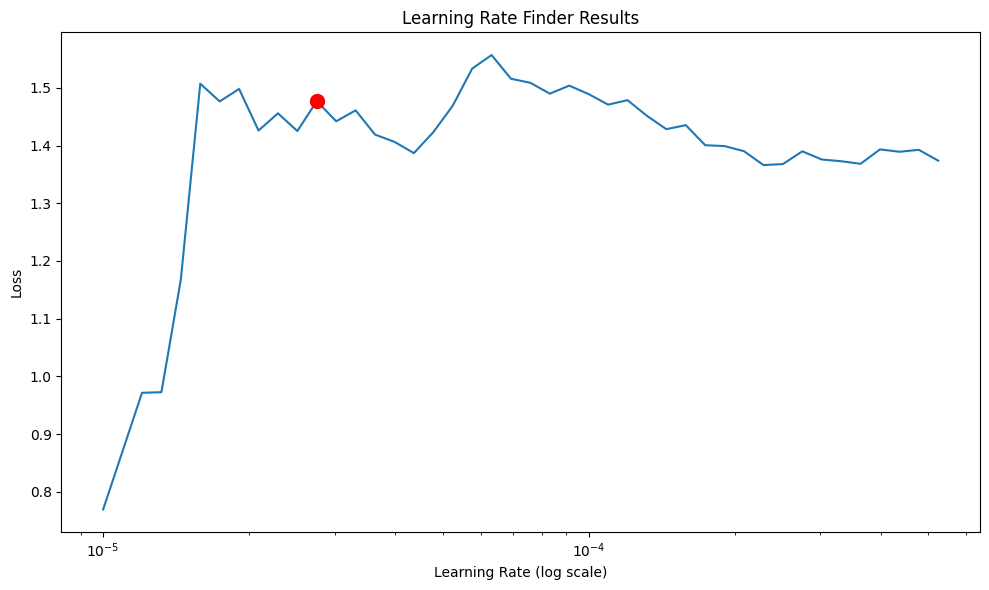

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00002754


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Training model for household_debt with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:  39%|███▉      | 39/100 [00:00<00:00, 348.53it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 319.20it/s]
Learning rate set to 0.00015848931924611134
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_b1178adb-04c4-4a49-83f8-f08744168bed.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_b1178adb-04c4-4a49-83f8-f08744168bed.ckpt


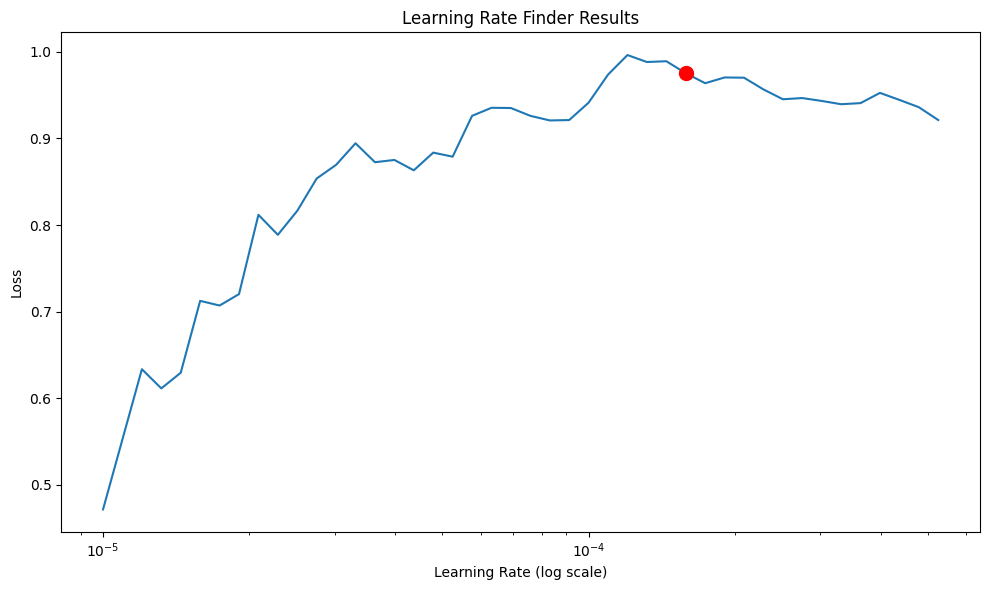

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00015849


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

In [60]:
max_lags_to_evaluate = 1  
variables_to_evaluate = ['log_GDP', 'household_debt']
from var import var
# takes a while to run
robust_check_results, robustness_dict = evaluate_models_with_lags(
    final_detrend, 
    train_dt_var, 
    test_dt_var, 
    variables_to_evaluate, 
    max_lags=max_lags_to_evaluate,
    seed = 16,
    window_size=window_size
)





Evaluating models with 1 lags...
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
      

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/conn

Optimizing hyperparameters for household_debt


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 


Best hyperparameters for log_GDP with lag 1:
  learning_rate: 7.339576861289311e-05
  hidden_size: 64
  num_layers: 2
  dropout: 0.2
  weight_decay: 1e-05
  batch_size: 16

Best hyperparameters for household_debt with lag 1:
  learning_rate: 3.330668179960056e-05
  hidden_size: 128
  num_layers: 1
  dropout: 0.5
  weight_decay: 1e-05
  batch_size: 64
Training model for log_GDP with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 557.69it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_5ed5e165-9ee6-4502-8314-9bd1f5b956e8.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_5ed5e165-9ee6-4502-8314-9bd1f5b956e8.ckpt


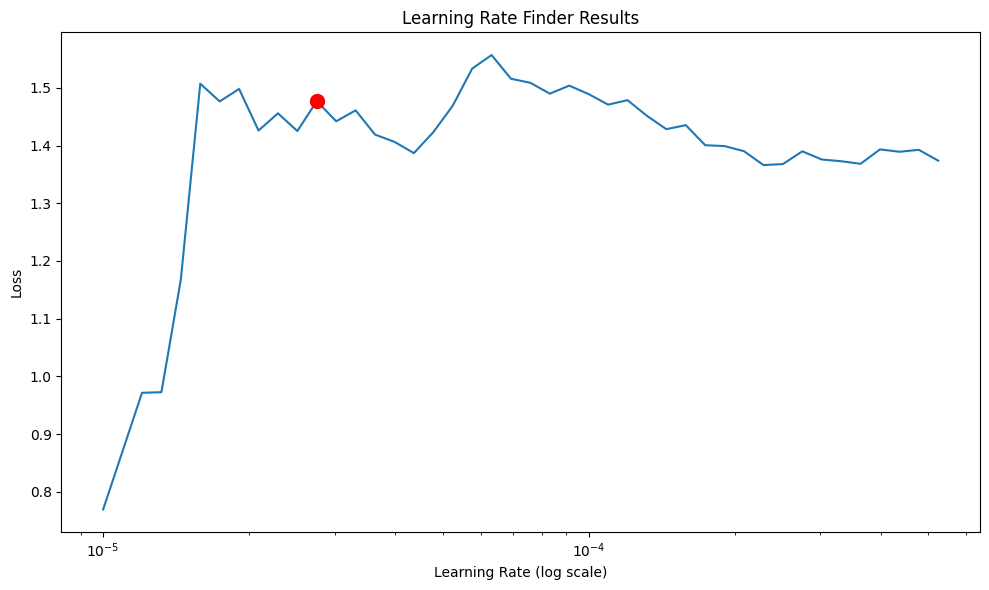

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00002754


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Training model for household_debt with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 532.09it/s]
Learning rate set to 0.00015848931924611134
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_4541fa79-37a0-420b-a110-57ece96d8cdd.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_4541fa79-37a0-420b-a110-57ece96d8cdd.ckpt


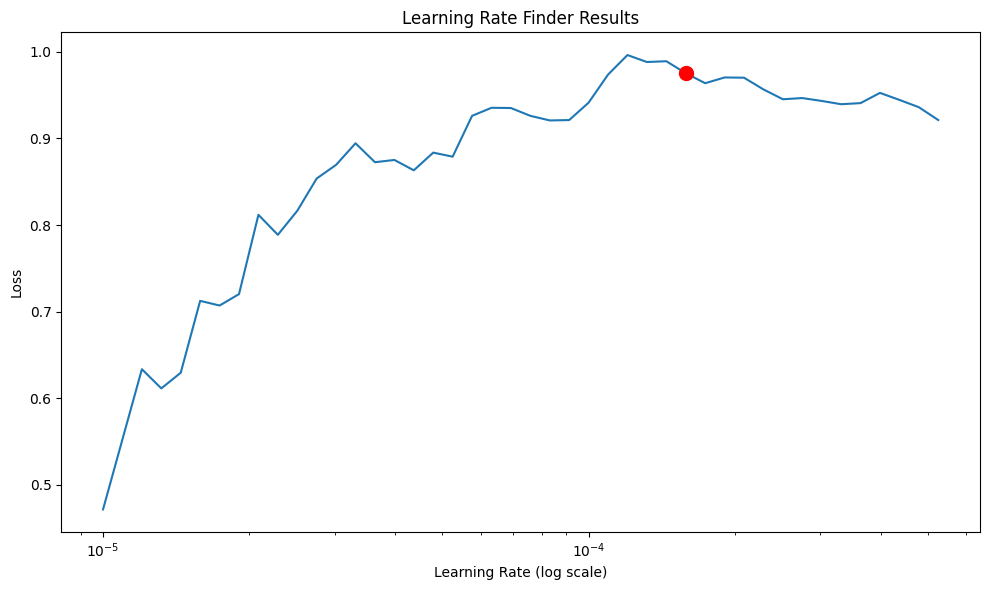

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00015849


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

In [61]:
max_lags_to_evaluate = 1  
variables_to_evaluate = ['log_GDP', 'household_debt']
from var import var
# takes a while to run
robust_check_results2, robustness_dict2 = evaluate_models_with_lags(
    final_detrend, 
    train_dt_var, 
    test_dt_var, 
    variables_to_evaluate, 
    max_lags=max_lags_to_evaluate,
    seed = 100,
    window_size=window_size
)


Evaluating models with 1 lags...
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
      

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Optimizing hyperparameters for log_GDP


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Optimizing hyperparameters for household_debt


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 


Best hyperparameters for log_GDP with lag 1:
  learning_rate: 0.00466187035569852
  hidden_size: 32
  num_layers: 3
  dropout: 0.4
  weight_decay: 0.01
  batch_size: 16

Best hyperparameters for household_debt with lag 1:
  learning_rate: 0.0015248805612076224
  hidden_size: 128
  num_layers: 2
  dropout: 0.1
  weight_decay: 0.0001
  batch_size: 32
Training model for log_GDP with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 559.02it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_498f4ff9-bb6c-4251-964a-460abef28b61.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_498f4ff9-bb6c-4251-964a-460abef28b61.ckpt


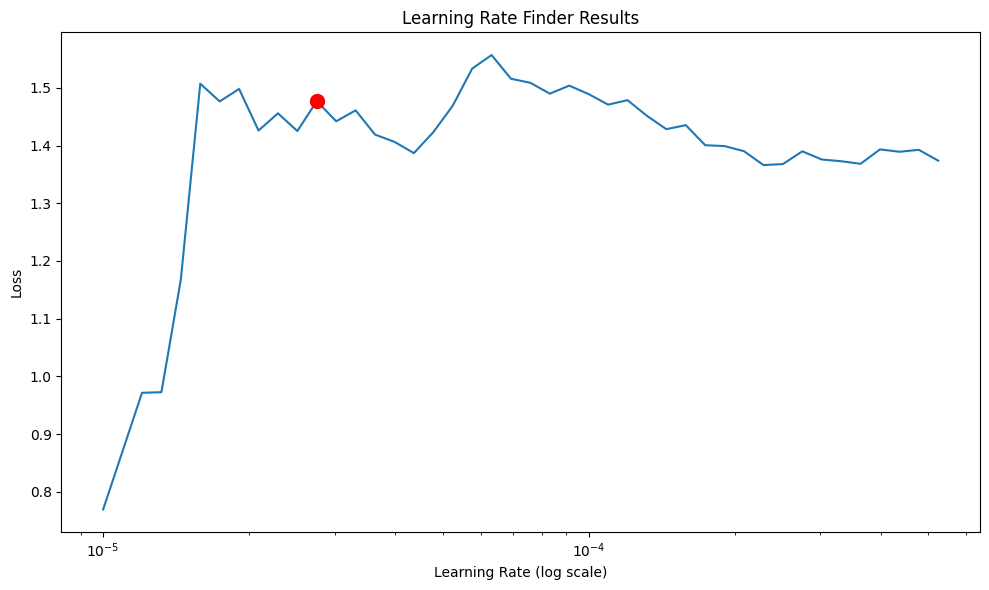

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00002754


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Training model for household_debt with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 557.83it/s]
Learning rate set to 0.00015848931924611134
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_6d6ea1ae-955f-4504-9880-a967daebba94.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_6d6ea1ae-955f-4504-9880-a967daebba94.ckpt


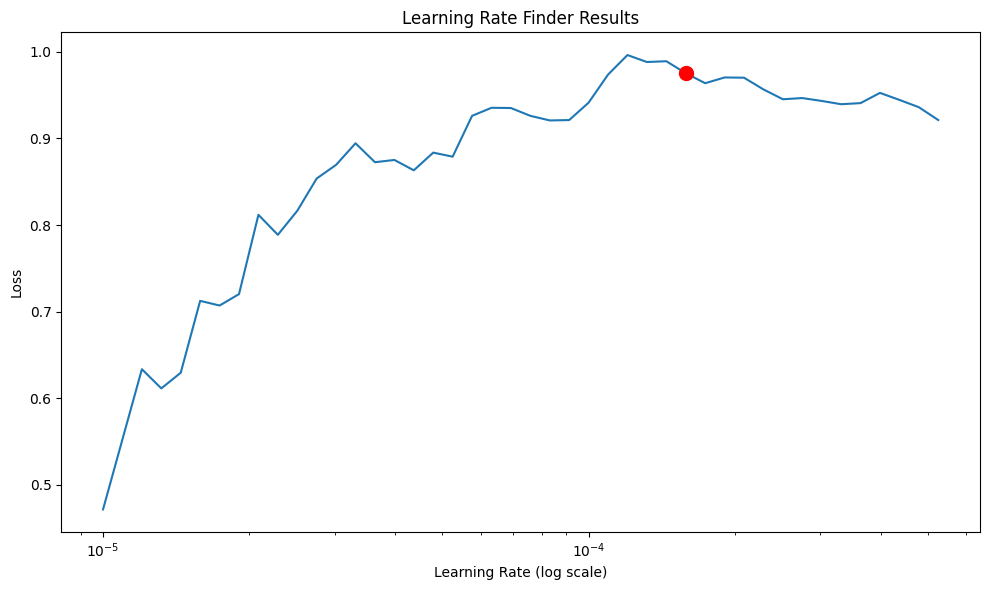

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00015849


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

In [62]:
max_lags_to_evaluate = 1  
variables_to_evaluate = ['log_GDP', 'household_debt']
from var import var
# takes a while to run
robust_check_results3, robustness_dict3 = evaluate_models_with_lags(
    final_detrend, 
    train_dt_var, 
    test_dt_var, 
    variables_to_evaluate, 
    max_lags=max_lags_to_evaluate,
    seed = 1,
    window_size=window_size
)



Evaluating models with 1 lags...
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
      

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
        l_GDP_dif_L1  hd_dif_L1
GDP_eq      0.052306   0.002383
HD_eq      -5.547507   0.315929
Starting hyperparameter optimization for lag 1...
Optimizing hyperparameters for log_GDP


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Optimizing hyperparameters for household_debt


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 


Best hyperparameters for log_GDP with lag 1:
  learning_rate: 0.00023974709913404535
  hidden_size: 16
  num_layers: 3
  dropout: 0.1
  weight_decay: 0.0001
  batch_size: 64

Best hyperparameters for household_debt with lag 1:
  learning_rate: 0.0003344036652141134
  hidden_size: 64
  num_layers: 1
  dropout: 0.2
  weight_decay: 1e-05
  batch_size: 64
Training model for log_GDP with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:  28%|██▊       | 28/100 [00:00<00:00, 275.12it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 306.44it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_87d4b6d1-eac4-4886-9c20-5f90b550ec7f.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_87d4b6d1-eac4-4886-9c20-5f90b550ec7f.ckpt


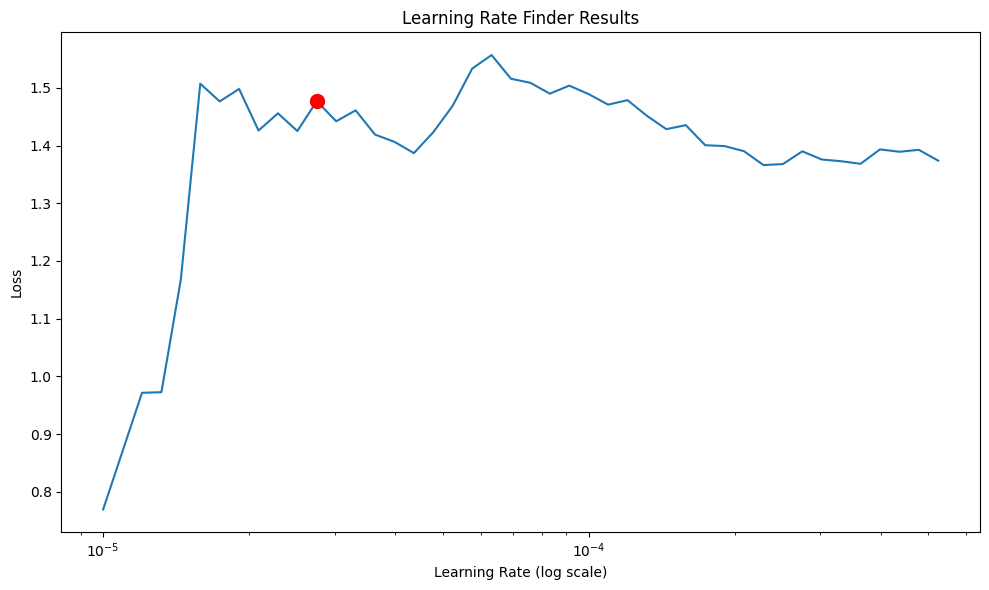

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00002754


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

Training model for household_debt with optimized hyperparameters...
Finding optimal learning rate...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 545.07it/s]
Learning rate set to 0.00015848931924611134
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_ab3d52a0-62d7-4007-9fa0-d8e73ee5cebb.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/experiments/HHD_GDP/.lr_find_ab3d52a0-62d7-4007-9fa0-d8e73ee5cebb.ckpt


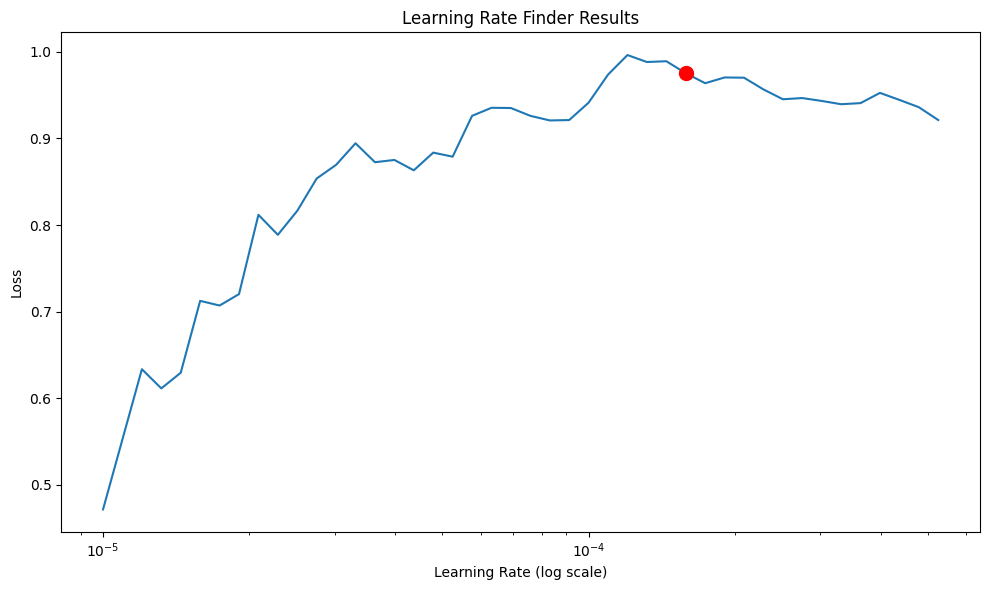

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Suggested learning rate: 0.00015849


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 

In [63]:
max_lags_to_evaluate = 1 
variables_to_evaluate = ['log_GDP', 'household_debt']
from var import var
# takes a while to run
robust_check_results4, robustness_dict4 = evaluate_models_with_lags(
    final_detrend, 
    train_dt_var, 
    test_dt_var, 
    variables_to_evaluate, 
    max_lags=max_lags_to_evaluate,
    seed = 1000,
    window_size=window_size
)

   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0


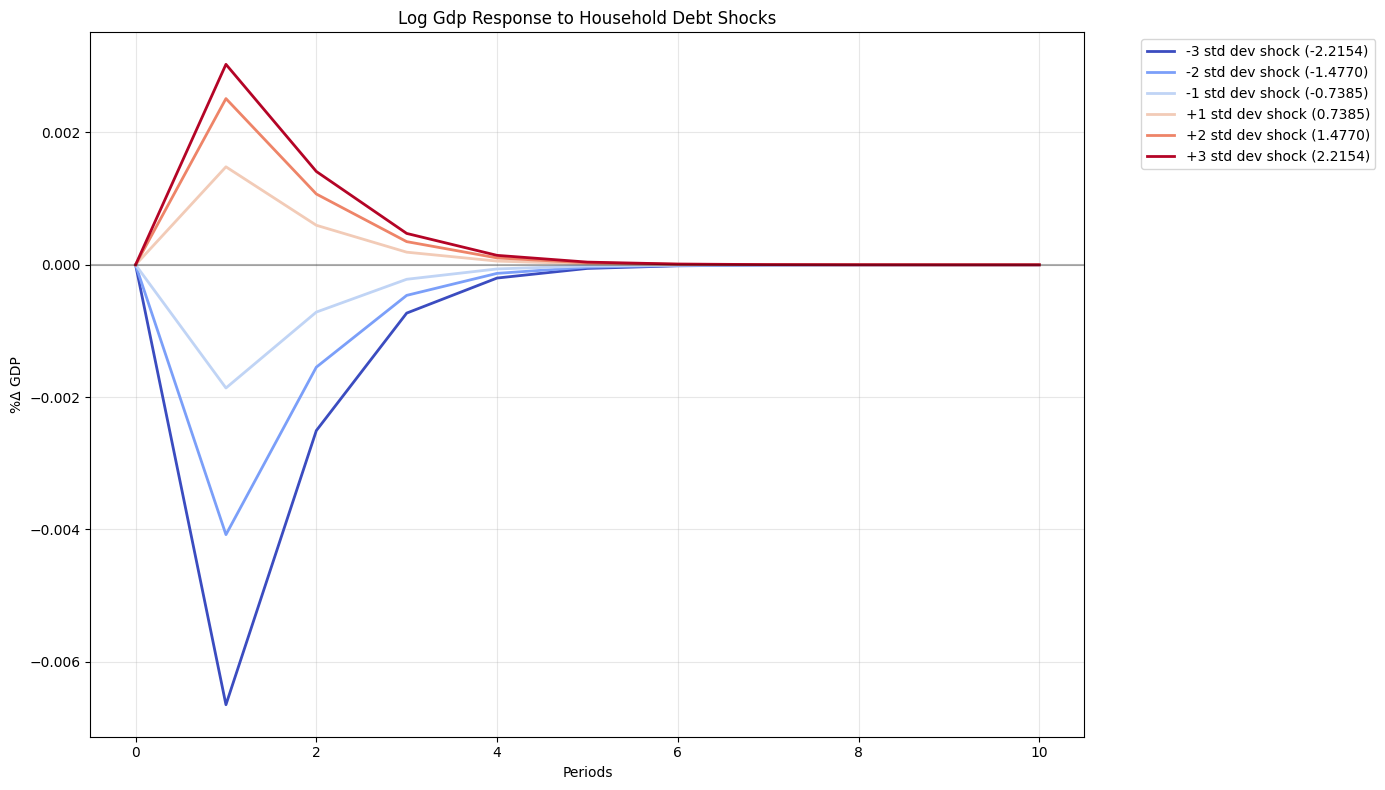

   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0


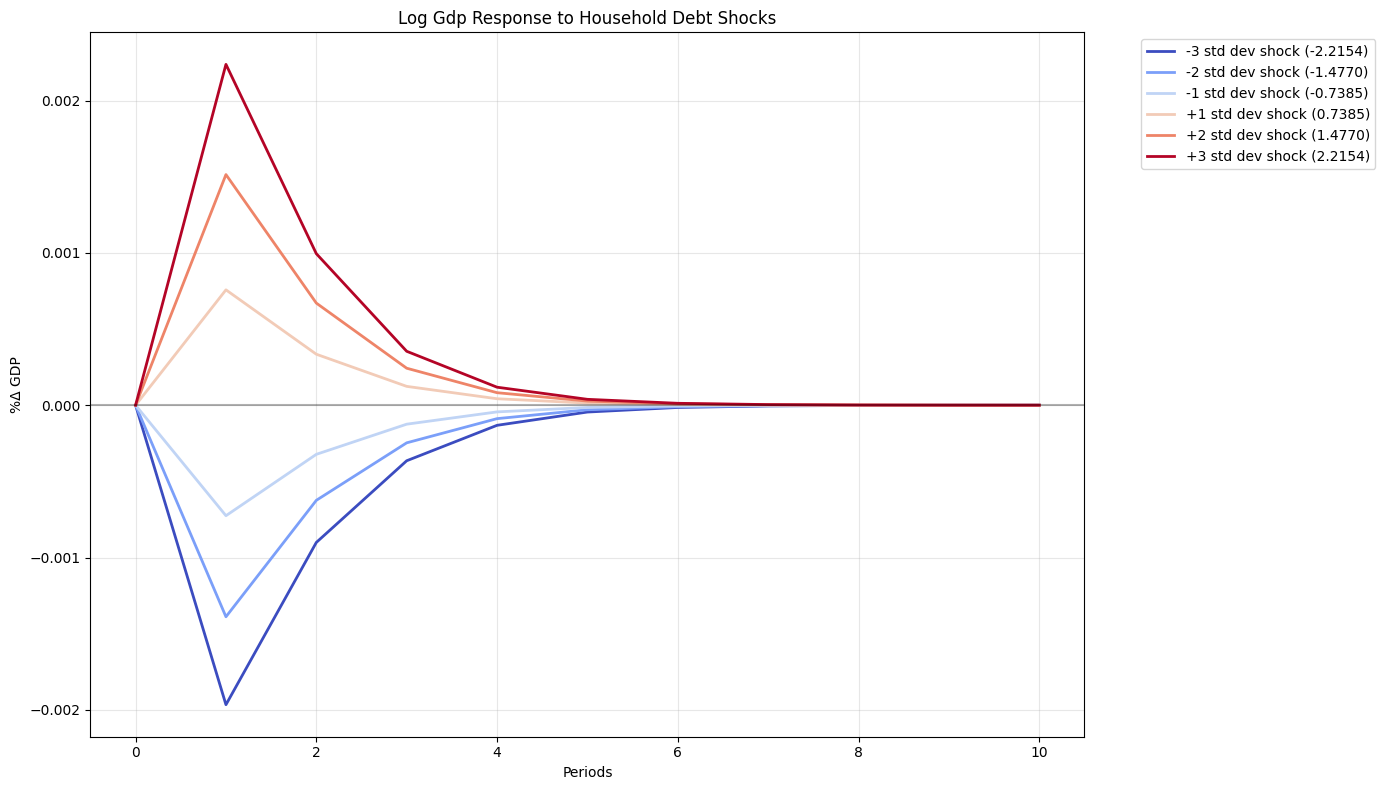

   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0


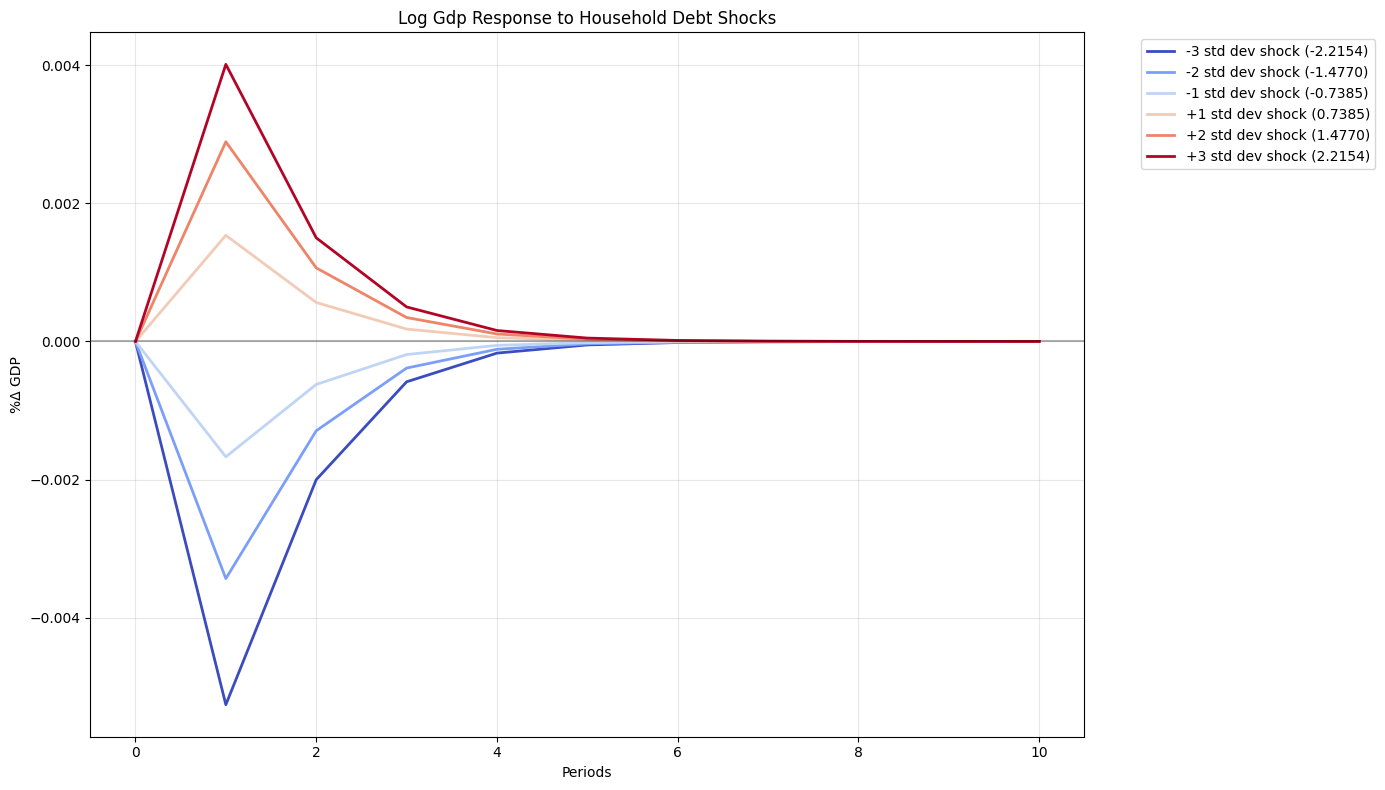

   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0


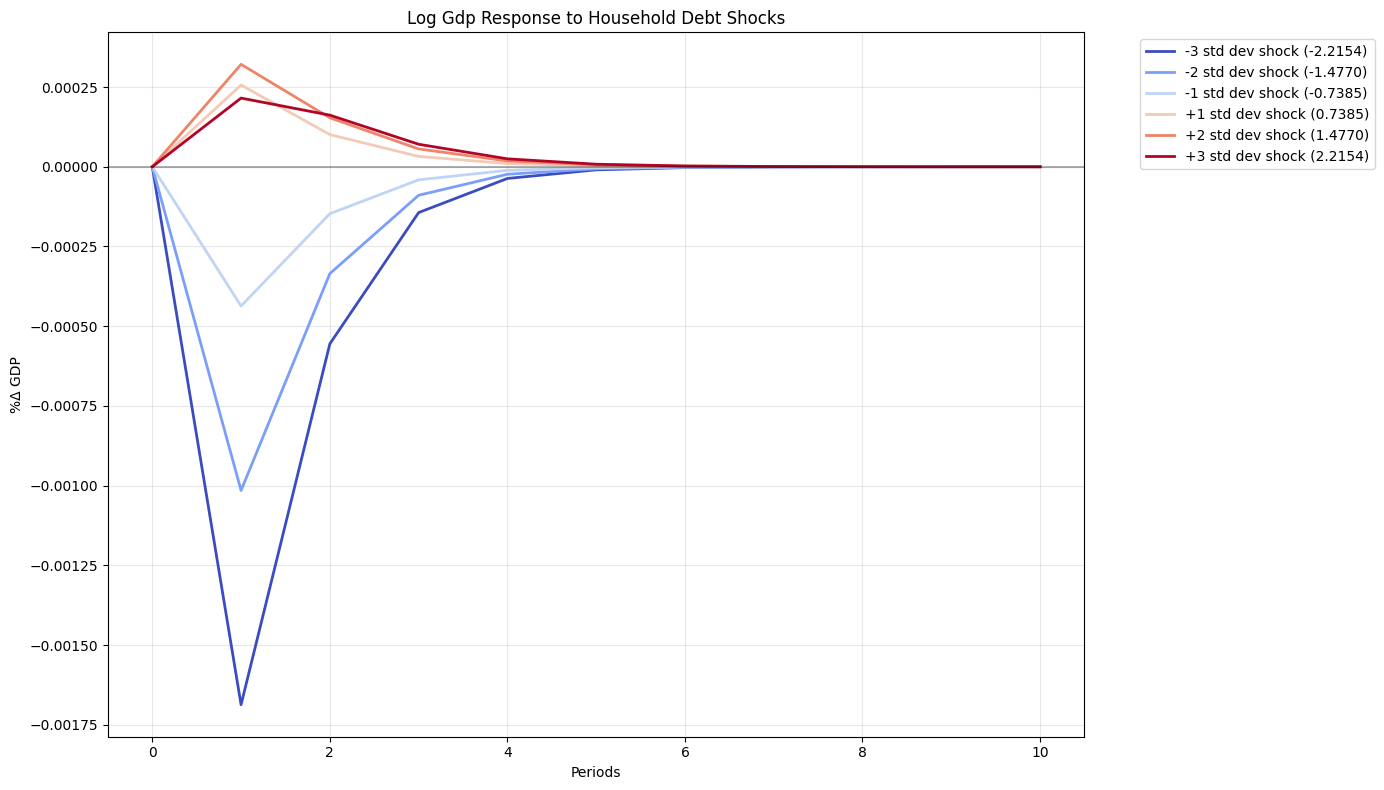

   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0
   log_GDP_lag1  household_debt_lag1
0           0.0                  0.0


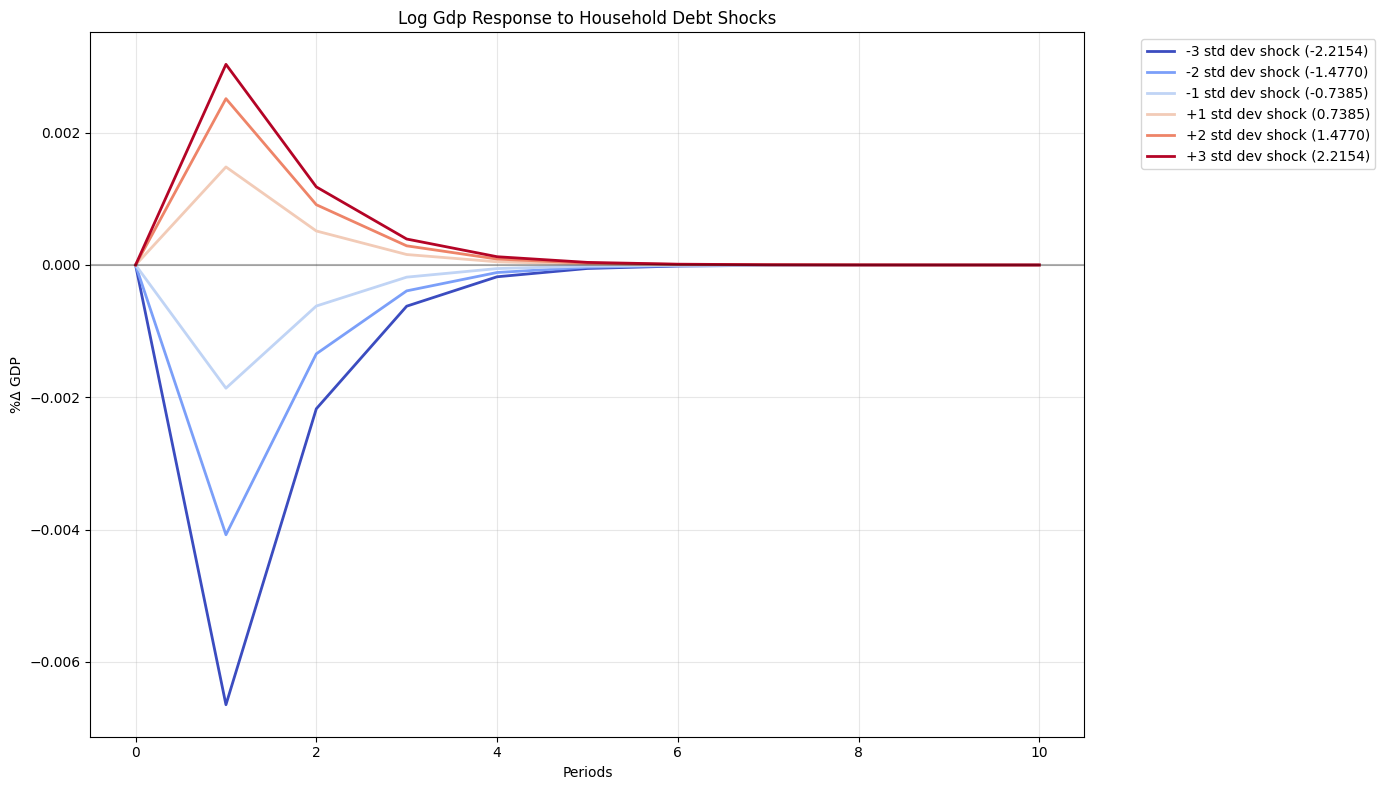

In [65]:
models = [model_dict_1, robustness_dict, robustness_dict2, robustness_dict3, robustness_dict4]
for model in models:
    for lag in range(1,2):
        lag_inputs = model_dict_1 [lag]['inputs']
        df_zeros = pd.DataFrame(np.zeros((1, len(lag_inputs))), columns=lag_inputs)
        plot_irf_with_multiple_shocks(
            df_zeros, 
            lag_inputs,  
            'household_debt_lag1', 
            'log_GDP', 
            model[lag]['model_dict'], 
            lag,  
            periods=10, 
            std_multipliers=std_multipliers
        )





In [1]:

# Generate LaTeX tables
latex_tables = create_latex_table_from_results(robust_check_results4, variables_to_evaluate)

# Display the LaTeX tables
for var_name, table in latex_tables.items():
    print(f"\nLaTeX table for {var_name}:")
    print(table)


NameError: name 'create_latex_table_from_results' is not defined

In [80]:
results = [all_results, robust_check_results, robust_check_results2, robust_check_results3, robust_check_results4]
for result in results:
    improvements = calculate_model_improvements(result)
    for variable in improvements:
        print(f"\nImprovements for {variable}:")
        for lag in improvements[variable]:
            print(f"  Lag {lag}:")
            for compare_model in improvements[variable][lag]:
                print(f"    vs {compare_model}:")
                for metric, value in improvements[variable][lag][compare_model].items():
                    print(f"      {metric}: {value:.2f}%")


Improvements for log_GDP:
  Lag 1:
    vs VAR:
      MSE: 11.17%
      RMSE: 5.75%
      MAE: 4.39%
    vs PVAR:
      MSE: 42.73%
      RMSE: 24.32%
      MAE: 37.57%

Improvements for household_debt:
  Lag 1:
    vs VAR:
      MSE: 21.60%
      RMSE: 11.46%
      MAE: 11.54%
    vs PVAR:
      MSE: 1.01%
      RMSE: 0.51%
      MAE: 0.41%

Improvements for log_GDP:
  Lag 1:
    vs VAR:
      MSE: -90.96%
      RMSE: -38.19%
      MAE: -80.00%
    vs PVAR:
      MSE: -23.12%
      RMSE: -10.96%
      MAE: -17.54%

Improvements for household_debt:
  Lag 1:
    vs VAR:
      MSE: -353.87%
      RMSE: -113.04%
      MAE: -171.40%
    vs PVAR:
      MSE: -473.08%
      RMSE: -139.39%
      MAE: -205.56%

Improvements for log_GDP:
  Lag 1:
    vs VAR:
      MSE: -236.15%
      RMSE: -83.34%
      MAE: -164.29%
    vs PVAR:
      MSE: -116.73%
      RMSE: -47.22%
      MAE: -72.57%

Improvements for household_debt:
  Lag 1:
    vs VAR:
      MSE: -20.38%
      RMSE: -9.72%
      MAE: -20.0